# Install libraries

In [65]:
!pip install missingno
!pip install tune-sklearn
!pip install catboost
!pip install scikit-optimize
# !pip install joblibspark
# !pip install pyspark

# Load libraries

In [66]:
import time
import numpy as np 
import numpy.ma as ma
import pandas as pd 
import datetime
import pickle
from tqdm import tqdm
import os
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingCVRegressor

from hyperopt import fmin, space_eval, tpe, hp

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV, train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

from scipy import stats
from scipy.stats import skew

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.eval_measures import rmse

from tune_sklearn import TuneSearchCV

from xgboost import XGBRegressor

from google.colab import drive
# Mount drive from Google
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Define functions

In [67]:
def cv_rmse(model, X=None, y=None):
    """
    Compute the root means squared error for models with cross-validation
    :param model: model desired
    :param X: features
    :param y: target variable

    :return rmse
    """
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

# Define function to get the best weights for stacking
def get_best_weights(df_x, number_models = 10, n_trials = 50):
  """
  Get the best weights for the stacking process
  :param df_x: Features
  :param number_models: Number of models considered in the stacking process
  :param n_trials: Number of trials to check

  :return best_weights and best_rmse
  """
  np.random.seed(random_state)
  weights_distr = np.random.uniform(low=1, high=10, size = number_models)
  weights_distr[0] = np.mean(weights_distr) + 30
  weights_distr[1] = np.mean(weights_distr) + 5
  weights_distr[2] = np.mean(weights_distr) + 5
  weights_distr[3] = np.mean(weights_distr) + 5
  weights_distr[4] = np.mean(weights_distr) + 5
  np.random.seed(random_state) 
  weights = np.random.dirichlet(weights_distr, n_trials)
  best_rmse = 999

  for i in range(n_trials):

    pred = ((weights[i][0] * stack_gen_model.predict(np.array(df_x)))
          + (weights[i][1] * cat_model_f.predict(df_x))
          + (weights[i][2] * lgbm_grid.best_estimator_.predict(df_x)) 
          + (weights[i][3] * xgb_grid.predict(df_x))
          + (weights[i][4] * gb_grid.predict(df_x))
          + (weights[i][5] * elasticnet_grid.best_estimator_.predict(df_x)) 
          + (weights[i][6] * lasso_grid.best_estimator_.predict(df_x))
          + (weights[i][7] * ridge_grid.best_estimator_.predict(df_x))
          + (weights[i][8] * svm_grid.predict(df_x))
          + (weights[i][9] * rf_grid.predict(df_x))
          # + (weights[i][10] * ann_grid.predict(df_x))
          # + (weights[i][10] * dt_grid.predict(df_x))
          
          )
    rmse_val = rmse(y_val, pred)

    if rmse_val < best_rmse:
      best_rmse = rmse_val
      best_weights = weights[i]
  
  return best_weights, best_rmse

# Get final prediction using the models trained

def ensemble_models_predict(df_x, weights):
  """
  Get the prediction using the stacking process
  :param df_x: Features
  :param weights: Best weights for the stacking process obtained with "get_best_weights" function

  :return best_weights and best_rmse
  """
  pred = ((weights[0] * stack_gen_model.predict(np.array(df_x)))
      + (weights[1] * cat_model_f.predict(df_x))
      + (weights[2] * lgbm_grid.best_estimator_.predict(df_x)) 
      + (weights[3] * xgb_grid.predict(df_x))
      + (weights[4] * gb_grid.predict(df_x))
      + (weights[5] * elasticnet_grid.best_estimator_.predict(df_x)) 
      + (weights[6] * lasso_grid.best_estimator_.predict(df_x))
      + (weights[7] * ridge_grid.best_estimator_.predict(df_x))
      + (weights[8] * svm_grid.predict(df_x))
      + (weights[9] * rf_grid.predict(df_x))
      # + (weights[10] * ann_grid.predict(df_x))
      # + (weights[10] * dt_grid.predict(df_x))

      )
  return pred

# Define function to calculate exploratory statistics (univariate)
def full_describe(dataframe,variables="all",variability=20,completeness=10): #summary, univariado, describe, analisis descriptivo, describir, analisis exploratorio
    #parameter description:
    #dataframe: Dataset to use in DataFrame format
    #variables: Variables to compute the univariate (EDA) analysis. Posible values: "all", input sequence (ie. "1:8"), 
    #input list of numbers or list of variable's names (ie. '1,4,9' o 'var1,var2,var3')
    #completeness: Minimum of accepted completeness per variable (value vetween 0 and 100)
    #variability: Minimum of accepted variability per variable (posible values: 0, 2, 10, 20, 50, 100)
    print("Describe process started, Time: "+ datetime.datetime.now().strftime("%H:%M:%S"))
    start1 = datetime.datetime.now()
    if variables == "all": #If you wish to analyze all the variables
        #Apply "describe" function and add  adicionar (concatenated) rows with Missing values
        resumen=pd.concat([dataframe.describe(include="all",percentiles =[0,0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99,1]), dataframe.isnull().sum().to_frame(name = 'missing').T],sort=False)
    elif ":" in variables: #If you wish to analyze the sequence of variables n1:n2
        #Apply "describe" function and add  adicionar (concatenated) rows with Missing values
        variables_serie=list(pd.to_numeric((variables).split(':')))
        variables_serie=list(pd.Series(range(variables_serie[0],variables_serie[1])))
        resumen=pd.concat([dataframe.iloc[:,variables_serie].describe(include="all",percentiles =[0,0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99,1]), dataframe.iloc[:,variables_serie].isnull().sum().to_frame(name = 'missing').T],sort=False)
    else:
        try: #If you wish to analyze variables of numericala array (positions)[n1,n2,n3,...]
            # Split variable by comma
            variables_serie=list(pd.to_numeric((variables).split(',')))
            #Apply "describe" function and add  adicionar (concatenated) rows with Missing values
            resumen=pd.concat([dataframe.iloc[:,variables_serie].describe(include="all",percentiles =[0,0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99,1]), dataframe.iloc[:,variables_serie].isnull().sum().to_frame(name = 'missing').T],sort=False)
        except: 
            if set(list(variables.split(","))).issubset(list(dataframe.columns)): #If you wish to analyze variables using array string (field names) ['nom1','nom2','nom3',...]
                # Split variable by comma, creating a string list
                variables_serie=list(variables.split(","))
                #Apply "describe" function and add  adicionar (concatenated) rows with Missing values
                resumen=pd.concat([dataframe.loc[:,variables_serie].describe(include="all",percentiles =[0,0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99,1]), dataframe.loc[:,variables_serie].isnull().sum().to_frame(name = 'missing').T],sort=False)
            else: #Garbage Collector for different cases
                resumen="Invalid entry for variables"
                
    print("Describe function calculatation finished. Elapsed Time: "+str((datetime.datetime.now() - start1).seconds)+" segs")
    
    start2 = datetime.datetime.now()
    print("Inicia calculo de completeness and variability, Time: "+ datetime.datetime.now().strftime("%H:%M:%S"))
    if isinstance(resumen, pd.DataFrame)==True: #Verify if there is any error in the imputed parameters 
        #Calculate total count of records
        resumen.loc['total count']=resumen.loc[['count','missing']].sum()
        #Calculate percentage os Missing values
        resumen.loc['% missing']=np.around((resumen.loc['missing']*100/resumen.loc['total count']).astype(np.double),4)
        #Transpose to use better the code
        resumen=resumen.T
        #Calculate variability
        resumen['variability'] = np.where(resumen['min']==resumen['max'], '00_variation', 
                                           np.where(resumen['1%']==resumen['99%'], '02_variation', 
                                                   np.where(resumen['5%']==resumen['95%'], '10_variation', 
                                                           np.where(resumen['10%']==resumen['90%'], '20_variation', 
                                                                   np.where(resumen['25%']==resumen['75%'], '50_variation', 
                                                                           'high_variation')))))
        if variability == 0:
            resumen['variability_decision'] = "accept"
        elif variability == 2:
            resumen['variability_decision'] = np.where(resumen['variability']=='00_variation', 'reject',
                                                        'accept')
        elif variability == 10:
            resumen['variability_decision'] = np.where((resumen['variability']=='00_variation') | (resumen['variability']=='02_variation'), 'reject',
                                                        'accept')
        elif variability == 20:
            resumen['variability_decision'] = np.where((resumen['variability']=='00_variation') | (resumen['variability']=='02_variation') | (resumen['variability']=='10_variation'), 'reject',
                                                        'accept')
        elif variability == 50:
            resumen['variability_decision'] = np.where((resumen['variability']=='00_variation') | (resumen['variability']=='02_variation') | (resumen['variability']=='10_variation') | (resumen['variability']=='20_variation'), 'reject',
                                                        'accept')
        elif variability == 100: 
            resumen['variability_decision'] = np.where((resumen['variability']=='00_variation') | (resumen['variability']=='02_variation') | (resumen['variability']=='10_variation') | (resumen['variability']=='20_variation') | (resumen['variability']=='50_variation'), 'reject',
                                                        'accept')
        else:
            resumen['variability_decision']="VALOR NO VALIDO"
            print("Invalid entry for parameter variability")
        #Calcular completeness
        resumen['completeness_decision']=np.where(resumen['% missing']==0,'accept_100',
                                                 np.where(resumen['% missing']>completeness, 'reject','accept')) 
    else:
        resumen="Invalid entry for variables"
        
    print("Completeness and variability calculation finished. Elapsed time: "+str((datetime.datetime.now() - start2).seconds)+" segs")
    
    
    print("Whole process completed. Total Elapsed time: "+str((datetime.datetime.now() - start1).seconds)+" segs")
    return resumen

# Define parameters

In [68]:
# Define paths
root_path = '/content/gdrive/MyDrive/Kaggle_competitions/House Prices - Advanced Regression Techniques'
output_path = root_path + '/output'
submissions_path = root_path + '/submissions'
models_path = root_path + '/models'

# Define random state for reproducibility
random_state = 0

# Load data from Kaggle

In [69]:
# Install kaggle
!pip -q install kaggle

# Upload the JSON file downloaded from kaggle (API token).
os.environ['KAGGLE_CONFIG_DIR'] = root_path + "/Kaggle"

kaggle_path = "'" + root_path +"/Kaggle'"
%cd $kaggle_path

# Download the dataset in zip format
# !kaggle datasets download -d nitishabharathi/scene-classification
!kaggle competitions download -c house-prices-advanced-regression-techniques

# # List all the datasets available in Kaggle
# # !kaggle datasets list

# #Decompress the data
# # !unzip -o -q scene-classification.zip

/content/gdrive/MyDrive/Kaggle_competitions/House Prices - Advanced Regression Techniques/Kaggle
test.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
data_description.txt: Skipping, found more recently modified local copy (use --force to force download)


# Load data

In [70]:
train = pd.read_csv("train.csv", sep=",")
test = pd.read_csv("test.csv", sep=",")

# Exploratory Data Analysis (EDA)

## Review Response Variable

In [71]:
# Check missing values
print(train[["SalePrice"]].isna().sum())

SalePrice    0
dtype: int64


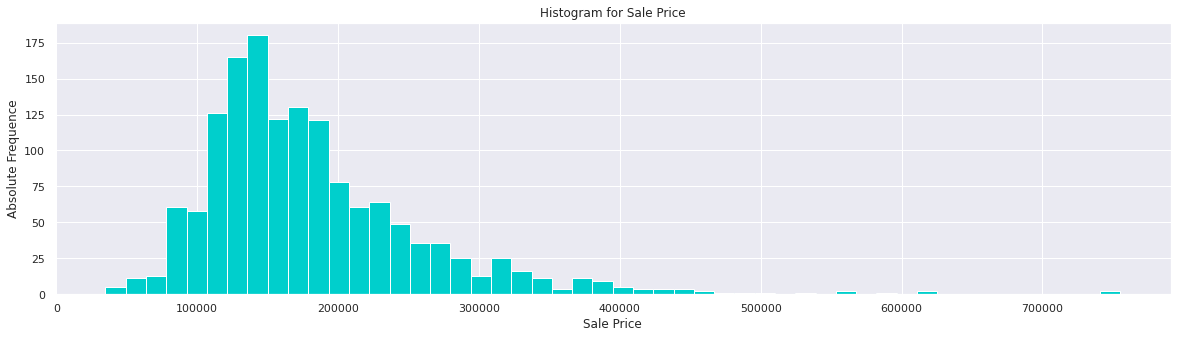

In [72]:
# Plotting results for fast comparisson
f, axs = plt.subplots(1,1,figsize=(20,5))
plt.subplot(1, 1, 1)
plt.hist(train["SalePrice"], label='Train', density=False, color ="#00cfcc", bins=50)
plt.xlabel('Sale Price')
plt.ylabel('Absolute Frequence')
plt.title(r'Histogram for Sale Price')
plt.show()

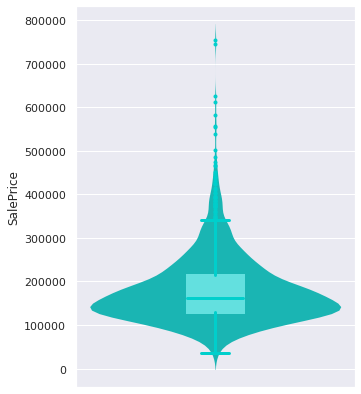

In [73]:
# Violin plot for SalePrice
sns.set(style="darkgrid", rc = {'figure.figsize':(5,7)})

ax = sns.violinplot(data=train, y='SalePrice', color="#00cfcc", inner=None, linewidth=0, width=0.9)
# ax.set_edgecolor('black')
haha = sns.boxplot(data=train, y='SalePrice', width=0.2
    ,medianprops={'color':'#00cfcc', 'linewidth':3}
    ,boxprops = dict(zorder= 1, linewidth=3, color='#63e0df'),       
    whiskerprops = dict(color='#00cfcc', linewidth=3),
    capprops = dict(color='#00cfcc', linewidth=3)
    ,flierprops = dict(marker='o', markersize=3,  markerfacecolor='#00cfcc', markeredgecolor='#00cfcc')
    , ax=ax)

plt.show()

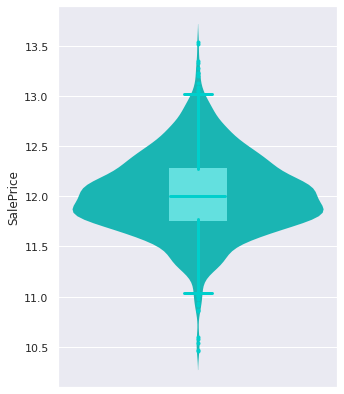

In [74]:
# Apply log (1 + SalesPrice) to correct skewness 
train["SalePrice"] = np.log1p(train["SalePrice"])
y = train['SalePrice'].reset_index(drop=True)

# Violin plot for SalePrice
sns.set(style="darkgrid", rc = {'figure.figsize':(5,7)})

ax = sns.violinplot(data=train, y='SalePrice', color="#00cfcc", inner=None, linewidth=0, width=0.9)
# ax.set_edgecolor('black')
haha = sns.boxplot(data=train, y='SalePrice', width=0.2
    ,medianprops={'color':'#00cfcc', 'linewidth':3}
    ,boxprops = dict(zorder= 1, linewidth=3, color='#63e0df'),       
    whiskerprops = dict(color='#00cfcc', linewidth=3),
    capprops = dict(color='#00cfcc', linewidth=3)
    ,flierprops = dict(marker='o', markersize=3,  markerfacecolor='#00cfcc', markeredgecolor='#00cfcc')
    , ax=ax)

plt.show()



## Pre-process to leave all the explanatory variables in one data set


In [75]:
# Eliminate ID
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

# Leave test and train features in one dataframe
train_features = train.drop(['SalePrice'], axis=1)
test_features = test
features = pd.concat([train_features, test_features]).reset_index(drop=True)

## Review Explanatory variables

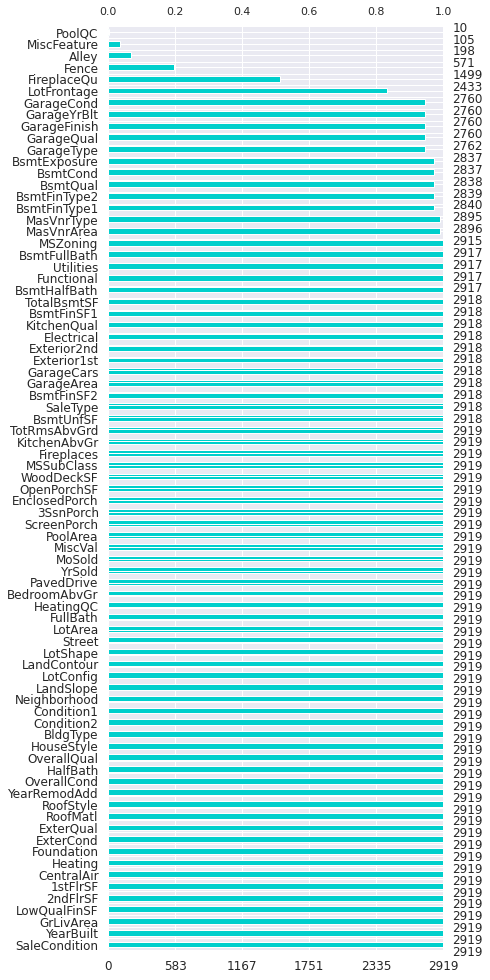

In [76]:
# Bar plot of missing values and percentage
msno.bar(features, labels=False, figsize=(6,17), fontsize=12, sort="descending", color="#00cfcc")

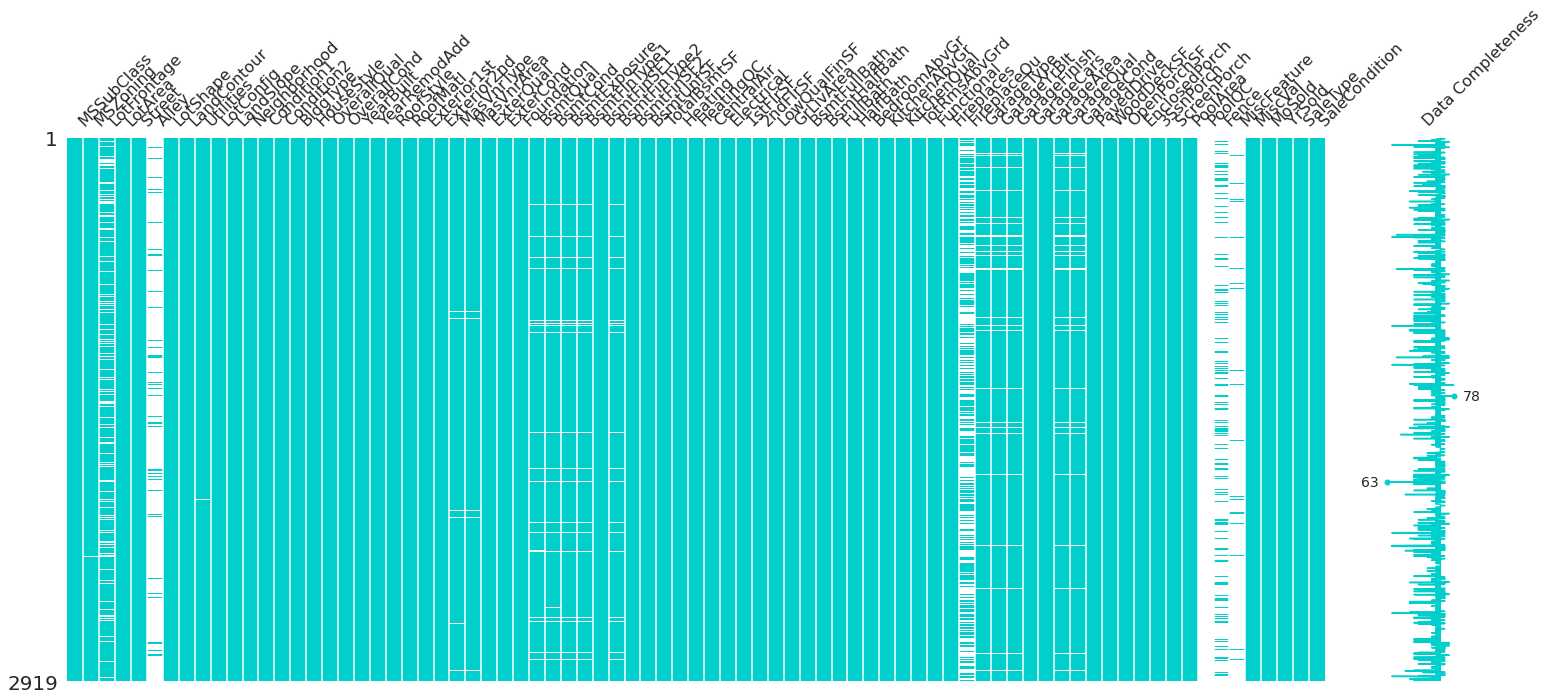

In [77]:
# Matrix showing the pisitions of the missing values for each variable
msno.matrix(features, labels=True, color = (0/255,207/255,204/255))

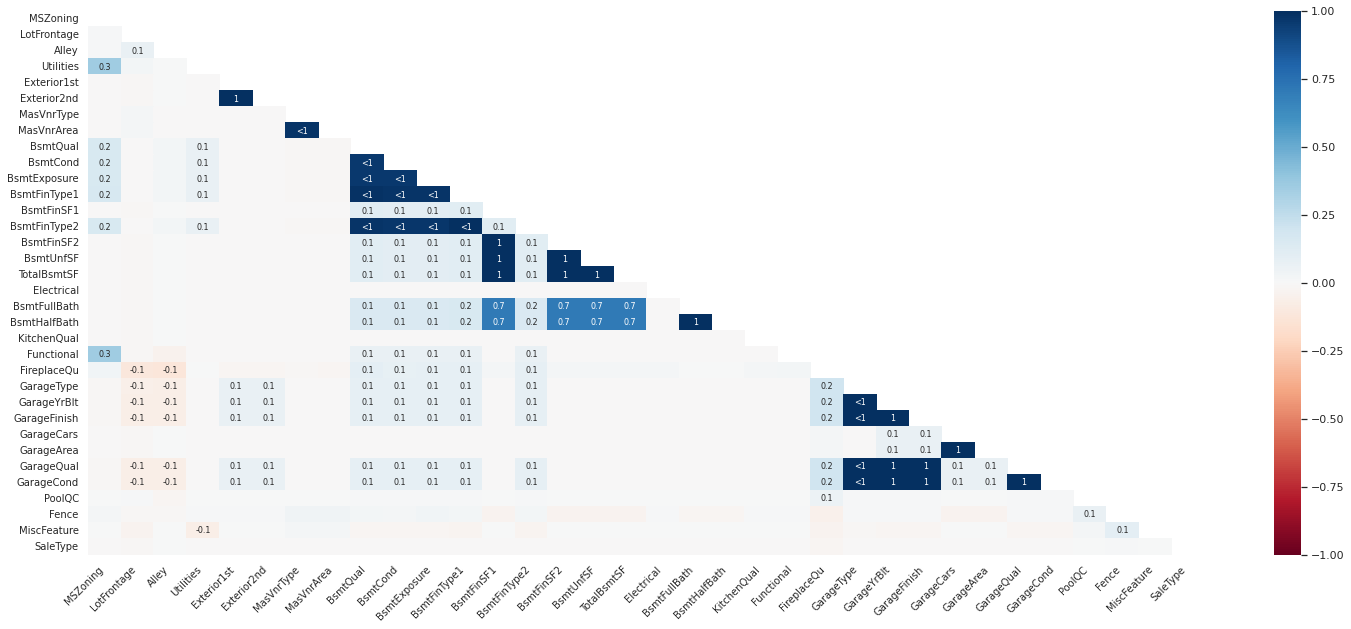

In [78]:
# Heat map showing correlation among variables
msno.heatmap(features, figsize=(25,10), fontsize=10)

In [79]:
# Execute univariate analysis (mainly or quantivative variables)
our_summary = full_describe(dataframe = features , variability = 20 , completeness = 10)

Describe process started, Time: 15:18:05
Describe function calculatation finished. Elapsed Time: 0 segs
Inicia calculo de completeness and variability, Time: 15:18:05
Completeness and variability calculation finished. Elapsed time: 0 segs
Whole process completed. Total Elapsed time: 0 segs


In [80]:
# Export summary to excel fileon the actual local machine to review
our_summary.to_excel(output_path + '/resumen_variables.xlsx', sheet_name = 'resumen')
# files.download("resumen_variables.xlsx")

[[1.0 0.4308089564200311]
 [0.4308089564200311 1.0]]


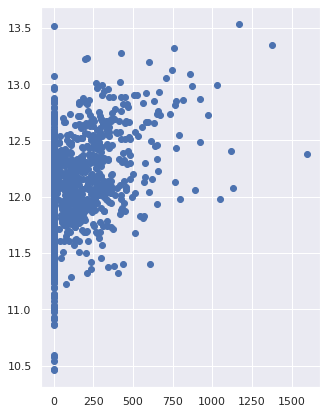

In [81]:
# Calculate correlation graphs for variables with missing values

plt.scatter(features.iloc[:len(y), :].MasVnrArea, y)

print(ma.corrcoef(ma.masked_invalid(features.iloc[:len(y), :].MasVnrArea), ma.masked_invalid(y)))

{'boxes': [<matplotlib.lines.Line2D at 0x7fbe87b82e50>],
 'caps': [<matplotlib.lines.Line2D at 0x7fbe87ca8d10>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fbe86ff6c10>],
 'means': [<matplotlib.lines.Line2D at 0x7fbe86ff6090>],
 'medians': [<matplotlib.lines.Line2D at 0x7fbe87ca8b90>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fbe86723110>,
  <matplotlib.lines.Line2D at 0x7fbe86723950>]}

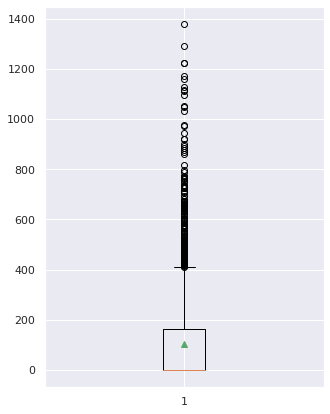

In [82]:
plt.boxplot(features.MasVnrArea[features.MasVnrArea<1600], showmeans=True)

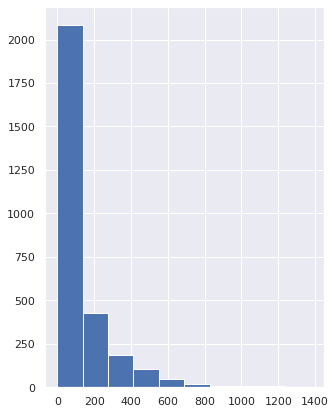

In [83]:
plt.hist(features.MasVnrArea[features.MasVnrArea<1600])
plt.show()

[[1.0 0.5410727772673495]
 [0.5410727772673495 1.0]]


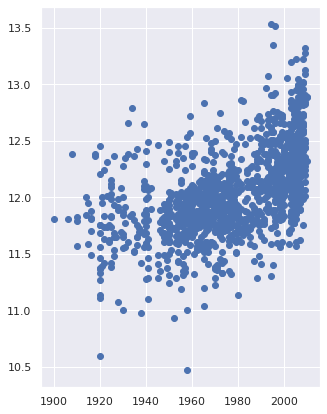

In [84]:
plt.scatter(features.iloc[:len(y), :].GarageYrBlt, y)

print(ma.corrcoef(ma.masked_invalid(features.iloc[:len(y), :].GarageYrBlt), ma.masked_invalid(y)))

{'boxes': [<matplotlib.lines.Line2D at 0x7fbe842d7490>],
 'caps': [<matplotlib.lines.Line2D at 0x7fbe842dd510>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fbe84264a50>],
 'means': [<matplotlib.lines.Line2D at 0x7fbe84264550>],
 'medians': [<matplotlib.lines.Line2D at 0x7fbe842ddfd0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fbe842d7a10>,
  <matplotlib.lines.Line2D at 0x7fbe842d7f90>]}

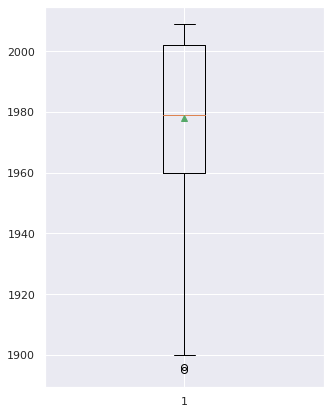

In [85]:
plt.boxplot(features.GarageYrBlt[features.GarageYrBlt<2010], showmeans=True)

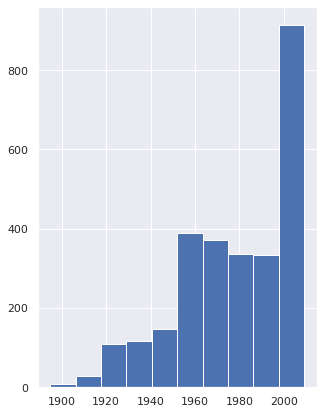

In [86]:
plt.hist(features.GarageYrBlt[features.GarageYrBlt<2010])
plt.show()

In [87]:
# Remove features that are not useful (a lot of missing):
features = features.drop(['PoolQC','MiscFeature','Alley','Fence','FireplaceQu'], axis=1)

# Remove features that are not useful (some categories with a few values):
features = features.drop(['Utilities', 'Street'], axis=1)
features = features.drop(['MasVnrType'], axis=1)

In [88]:
# Since these column are actually a category , using a numerical number will lead the model to assume
# that it is numerical , so we convert to string .
features['MSSubClass'] = features['MSSubClass'].apply(str)
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)

In [89]:
# Fill missing value with 0 for continuos variables
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics.append(i)
features.update(features[numerics].fillna(0))

In [90]:
# Fill missing with mode for categorical variables 
objects = []
for i in features.columns:
    if features[i].dtype == object:
        objects.append(i)
features.update(features[objects].fillna(features.mode().iloc[0]))

# Feature Engineering

In [91]:
# Adding new features. Sums of categiries.

features['YrBltAndRemod']=features['YearBuilt']+features['YearRemodAdd']
features['TotalSF']=features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']

features['Total_sqr_footage'] = (features['BsmtFinSF1'] + features['BsmtFinSF2'] +
                                 features['1stFlrSF'] + features['2ndFlrSF'])

features['Total_Bathrooms'] = (features['FullBath'] + (0.5 * features['HalfBath']) +
                               features['BsmtFullBath'] + (0.5 * features['BsmtHalfBath']))

features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                              features['EnclosedPorch'] + features['ScreenPorch'] +
                              features['WoodDeckSF'])

# If PoolArea = 0 , Then HasPool = 0 too, ...

features['haspool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
features['has2ndfloor'] = features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasgarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
features['hasbsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasfireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

features["SqFtPerRoom"] = features["GrLivArea"] / (features["TotRmsAbvGrd"] +
                                                       features["FullBath"] +
                                                       features["HalfBath"] +
                                                       features["KitchenAbvGr"])

features['Total_Home_Quality'] = features['OverallQual'] + features['OverallCond']

features["HighQualSF"] = features["1stFlrSF"] + features["2ndFlrSF"]

features.shape

(2919, 84)

In [92]:
''' Calculating correlation of all the categorical Variables against the ['SalePrice'] one at the time '''

# List with all categoricals Variables
lista_variables = ["LotShape", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "Electrical", "GarageType", "GarageFinish", "GarageQual", "GarageCond", "MSZoning", 
                   "LandContour", "LotConfig", "LandSlope","Neighborhood","Condition1","Condition2","BldgType","HouseStyle","RoofStyle","RoofMatl","Exterior1st","Exterior2nd","ExterQual","ExterCond",
                   "Foundation","Heating","HeatingQC","CentralAir","KitchenQual" ,"Functional","PavedDrive","SaleType","SaleCondition"]

df_X = []
corr_vars_cat = pd.DataFrame(columns=['variable','fvalue','pvalue','-log_pvalue'])
# we iterate over each variable
for variable in tqdm(lista_variables):
    # We need to clear the list for each iteration.
    df_X.clear()   
    # then, for each variable, we iterate over each one of its category
    for categoria in list(set(features[variable].values)):
        res = pd.concat([features, y],axis=1).loc[features[variable] == categoria]['SalePrice']
        df_X.append(res)

    fvalue, pvalue = stats.kruskal(*df_X, nan_policy = 'omit')
    
    row_to_append = pd.DataFrame({'variable': [variable], 'fvalue': [fvalue], 'pvalue': [pvalue], '-log_pvalue': [-np.log(pvalue)]})
    corr_vars_cat = pd.concat([corr_vars_cat, row_to_append], axis=0)
    # print("===============================================================================================================")
    # print("test: F-value",fvalue,"P-value", pvalue,"-log(P-value)",-np.log(pvalue))
    #print("VAR:{0:s} CAT:{1:s} F-VAL:{2:10.6f} PVAL:{3:10.6f} LOG:{4:10.6f}".format(variable, categoria, fvalue, pvalue, -np.log(pvalue)))


corr_vars_cat.sort_values('-log_pvalue', ascending = False)

100%|██████████| 35/35 [00:11<00:00,  2.96it/s]


,variable,fvalue,pvalue,-log_pvalue
0,Neighborhood,868.532376,6.696799e-168,384.932666
0,ExterQual,683.440084,8.180798e-148,338.680804
0,KitchenQual,661.481587,4.720113e-143,327.717836
0,BsmtQual,659.020743,1.612542e-142,326.489272
0,GarageFinish,578.915601,1.950179e-126,289.457801
0,Foundation,488.722751,2.169096e-103,236.391954
0,HeatingQC,356.776407,6.036449e-76,173.198651
0,GarageType,339.621474,3.001070e-71,162.384573
0,BsmtFinType1,305.776912,5.735444e-64,145.618781
0,MSZoning,270.070197,3.080724e-57,130.122186


In [93]:
# Reviewing the categories of categorical variables
var_desired = 'RoofStyle'
print(features[var_desired].value_counts())
features.columns[features.columns.str.contains(var_desired)]

Gable      2310
Hip         551
Gambrel      22
Flat         20
Mansard      11
Shed          5
Name: RoofStyle, dtype: int64


Index(['RoofStyle'], dtype='object')

In [94]:
# Create dummie variables and stack them with the whole dataframe
final_features = pd.get_dummies(features).reset_index(drop=True)
final_features.shape

(2919, 305)

In [95]:
# Find highly skewed features
numeric_features = final_features.dtypes[final_features.dtypes != object].index
skewed_features = final_features[numeric_features].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skewed_features[skewed_features > 0.5]
skew_index = high_skew.index

# Normalize skewed features using log_transformation
for i in skew_index:
    final_features[i] = np.log1p(final_features[i])

In [96]:
# Divide features of train and test
X = final_features.iloc[:len(y), :]
X_sub = final_features.iloc[len(y):, :]
X.shape, y.shape, X_sub.shape

((1460, 305), (1460,), (1459, 305))

In [97]:
# # Define cuantitative variables to be upper and lower capped 
# vars_upper_cap = ['MSSubClass','LotArea','OverallCond','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','GrLivArea','BsmtFullBath','BsmtHalfBath','BedroomAbvGr','TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','ScreenPorch']
# vars_lower_cap = ['LotArea','OverallQual','OverallCond','YearBuilt','TotalBsmtSF','BedroomAbvGr','GarageYrBlt']

In [98]:
# # Capping values with 95th and 5th percentiles
# for col in features.columns:
#     if(features[col].dtype) != 'O':
#       if col in vars_upper_cap:
#         features[col] = pd.Series(np.where(features[col] >= features[col].quantile(0.999), features[col].quantile(0.999), features[col]))
#         # print(col)
#         # print(features[col].values)
#       if col in vars_lower_cap:
#         features[col] = pd.Series(np.where(features[col] <= features[col].quantile(0.009), features[col].quantile(0.009), features[col]))
#         # print(col)
#         # print(df[col].values)

In [99]:
# Removing outliers.
# Can be seen by plotting them in a graph.

outliers = [30, 88, 462, 631, 1322]

X = X.drop(X.index[outliers])
y = y.drop(y.index[outliers])

X.shape, y.shape, X_sub.shape

((1455, 305), (1455,), (1459, 305))

In [100]:
# Calculate correlation matrix to check correlation with the response variable SalePrice
corr_matrix = pd.concat([X,y],axis=1).corr()
corr_matrix = corr_matrix[['SalePrice']].sort_values('SalePrice',ascending=False)
# Export summary to excel file on the actual local machine to review
corr_matrix.to_excel(output_path + '/correlation.xlsx', sheet_name = 'correlation')
# files.download("correlation.xlsx")

In [101]:
# Divide data in train and an auxiliar for validation/test randomly, taking the train size as 60% of the whole data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = random_state)

# Divide auxiliar data in valdiation/train randomly, taking the validation and train size as 15% (for each) of the whole data
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size = 0.5, random_state = random_state)

print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Validation shape:",x_val.shape)
print("Y Validation shape:",y_val.shape)
print("X Test shape:",x_test.shape)
print("Y Test shape:",y_test.shape)

X Train shape: (873, 305)
Y Train shape: (873,)
X Validation shape: (291, 305)
Y Validation shape: (291,)
X Test shape: (291, 305)
Y Test shape: (291,)


# Modelling

# Applying Multiple Linear regression technique

In [102]:
# Select the explanatory variables to be used
vars_select = ['OverallQual','Fireplaces','HalfBath','BsmtFullBath','BedroomAbvGr','KitchenAbvGr','OverallCond','MSSubClass']

x_train = x_train.loc[:, x_train.columns.isin(vars_select)].copy()
x_val = x_val.loc[:, x_val.columns.isin(vars_select)].copy()
x_test = x_test.loc[:, x_test.columns.isin(vars_select)].copy()

# Add a column full of 1 to estimate the intercept parameter 
x_train = sm.add_constant(x_train)
x_val = sm.add_constant(x_val)
x_test = sm.add_constant(x_test)

# Define model
model = sm.OLS(y_train, x_train)
# Fit model
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     354.7
Date:                Fri, 25 Feb 2022   Prob (F-statistic):          3.63e-249
Time:                        15:18:28   Log-Likelihood:                 164.76
No. Observations:                 873   AIC:                            -313.5
Df Residuals:                     865   BIC:                            -275.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           10.2279      0.111     92.243   

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [103]:
# Checking assumptions
# Multicolinearity
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
aux = x_train.drop(['const'],axis=1)
# aux = x_train.copy()
vif["VIF Factor"] = [variance_inflation_factor(aux.values, i) for i in range(aux.shape[1])]
vif["features"] = aux.columns
print("======================================================================================")
print("Multicolinarity check using VIF:")
print(vif.sort_values('VIF Factor',ascending=False).round(1))

# Get residuals
residuals = results.resid

# Independence of errors
print("======================================================================================")
print("Independence of errors check using Durbin-Watson test:")
dw_stats = sm.stats.stattools.durbin_watson(residuals, axis=0)
print("D-W statistic:", dw_stats)
if dw_stats <= 2.5 and dw_stats >= 1.5:
  print("Residuals are independent")
else:
  print("Residuals are NOT independent")

# Homocedasticity
fvalue, f_pvalue, ordering = sm.stats.diagnostic.het_goldfeldquandt(y_train, x_train)
print("======================================================================================")
print("Homocedasticity check using Goldfeld-Quandt test:")
print("F-value",fvalue,"P-value", f_pvalue)

print("======================================================================================")
# Predict values of regression with train
ypred_train = results.predict(x_train)
# Predict values of regression with validation
ypred_val = results.predict(x_val)
# Predict values of regression with test
ypred_test = results.predict(x_test)

print("Evaluating results of the regression:")
print("RMSE Score for train, validation, test: {}, {}, {}".format(rmse(y_train, ypred_train), rmse(y_val, ypred_val), rmse(y_test, ypred_test)))

Multicolinarity check using VIF:
   VIF Factor      features
1        55.4   OverallCond
5        50.5  KitchenAbvGr
0        23.2   OverallQual
4        16.6  BedroomAbvGr
6         2.6    Fireplaces
3         1.9      HalfBath
2         1.8  BsmtFullBath
Independence of errors check using Durbin-Watson test:
D-W statistic: 1.9184251762180786
Residuals are independent
Homocedasticity check using Goldfeld-Quandt test:
F-value 1.2471774780261722 P-value 0.011225461463968418
Evaluating results of the regression:
RMSE Score for train, validation, test: 0.20035559108434017, 0.19873854846866182, 0.20249805232301749


# Get train, validation and test data

In [104]:
# Divide data in train and an auxiliar for validation/test randomly, taking the train size as 60% of the whole data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = random_state)

# Divide auxiliar data in valdiation/train randomly, taking the validation and train size as 15% (for each) of the whole data
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size = 0.5, random_state = random_state)

# X = x_train
# y = y_train

print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Validation shape:",x_val.shape)
print("Y Validation shape:",y_val.shape)
print("X Test shape:",x_test.shape)
print("Y Test shape:",y_test.shape)

# Define parameters for fine tuning

num_folds = 5

kf = KFold(n_splits=num_folds, random_state=random_state, shuffle=True)

X Train shape: (873, 305)
Y Train shape: (873,)
X Validation shape: (291, 305)
Y Validation shape: (291,)
X Test shape: (291, 305)
Y Test shape: (291,)


## Applying XG-Boost technique

In [105]:
# Set flag to train or load model 
# To load the model then: load_model = True
# To train the model then: load_model = False
load_model = True

print("======================================================================================")
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Validation shape:",x_val.shape)
print("Y Validation shape:",y_val.shape)
print("X Test shape:",x_test.shape)
print("Y Test shape:",y_test.shape)

start_time = time.time()
#Print the optimal hyperparameters
if load_model:
  # Load model
  infile = open(models_path + '/XGboost_model.pkl','rb')
  xgb_grid = pickle.load(infile)
  infile = open(models_path + '/best_params_XGboost.pkl','rb')
  best_params = pickle.load(infile)
else:
  # Define function to minimize
  def param_selection_cv(params, random_state=random_state, cv=kf, X=x_train, y=y_train):
      
      # Use params to create new model
      model = make_pipeline( XGBRegressor(random_state = random_state, **params))

      # Do cross validation with the same folds
      score = -cross_val_score(model, X, y, cv=cv, scoring="neg_root_mean_squared_error", n_jobs = -1,error_score = 'raise').mean()

      return score

  # Define grid (space)
  parameters = {'max_depth': hp.choice('max_depth', range(3,10,1))
        , 'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1)
        , 'n_estimators': hp.choice('n_estimators', [300])
        , 'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1)
        , 'reg_alpha' : hp.quniform('reg_alpha', 0,1,1)
        # , 'reg_lambda' : hp.uniform('reg_lambda', 0,1)
        # , 'gamma': hp.uniform ('gamma', 0,0.5)
    }

  # Minimize function
  best = fmin(fn = param_selection_cv 
            , space = parameters 
            , algo = tpe.suggest 
            , max_evals = 10
            , rstate = np.random.RandomState(random_state)
          )
  
  # Retrieve best hyperparameters
  best_params = space_eval(parameters, best)

  # Define model with best hyperparameters
  xgb_grid = make_pipeline( XGBRegressor(random_state = random_state, **best_params))

  # Train Model
  xgb_grid.fit(x_train,y_train)
  
  #Save model
  with open(models_path + '/XGboost_model.pkl', 'wb') as pickfile:
     pickle.dump(xgb_grid, pickfile)
  with open(models_path + '/best_params_XGboost.pkl', 'wb') as pickfile:
     pickle.dump(best_params, pickfile)
print("======================================================================================")
print("Best parameters found: ")
print(best_params)

print("======================================================================================")
# Predict values of regression with train
ypred_train = xgb_grid.predict(x_train)
# Predict values of regression with validation
ypred_val = xgb_grid.predict(x_val)
# Predict values of regression with test
ypred_test = xgb_grid.predict(x_test)

print("Evaluating results of the regression:")
print("RMSE Score for train, validation, test: {:.5f}, {:.5f}, {:.5f}".format(rmse(y_train, ypred_train), rmse(y_val, ypred_val), rmse(y_test, ypred_test)))

# Feature importance calculation
# imps = permutation_importance(xgb_grid.best_estimator_, x_train, y_train)

# Create dummie variables and stack them with the previous dataframe
# importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
# importance.columns = ["variable","importance"]

# importance = importance.sort_values(by='importance', ascending=False)
print("======================================================================================")
print("Feature importance:")
# print(importance)

print("Ejecución: %s seconds" % (time.time() - start_time))

X Train shape: (873, 305)
Y Train shape: (873,)
X Validation shape: (291, 305)
Y Validation shape: (291,)
X Test shape: (291, 305)
Y Test shape: (291,)
[15:18:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best parameters found: 
{'colsample_bytree': 0.5921396188580523, 'max_depth': 5, 'min_child_weight': 8.0, 'n_estimators': 300, 'reg_alpha': 1.0}
Evaluating results of the regression:
RMSE Score for train, validation, test: 0.06766, 0.13178, 0.12612
Feature importance:
Ejecución: 0.1333909034729004 seconds


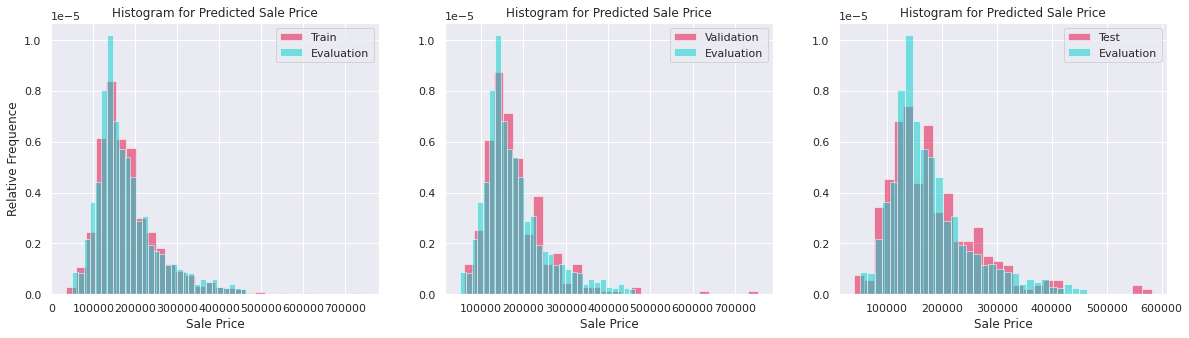

In [106]:
#  Load test data
df_evaluation = pd.read_csv("sample_submission.csv", sep=",")

# Make prediction over evaluation data
df_evaluation.iloc[:,1] = np.expm1(pd.DataFrame(xgb_grid.predict(X_sub)))

# Plotting results for fast comparisson
# plt.hist(y_test)
f, axs = plt.subplots(2,2,figsize=(20,5))
plt.subplot(1, 3, 1)
plt.hist(np.expm1(y_train),alpha = 0.5, label='Train', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.ylabel('Relative Frequence')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.subplot(1, 3, 2)
plt.hist(np.expm1(y_val),alpha = 0.5, label='Validation', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.subplot(1, 3, 3)
plt.hist(np.expm1(y_test),alpha = 0.5, label='Test', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.show()

# Export file to submit in competition
df_evaluation.to_csv(submissions_path + '/House_Prices_ART_XGBOOST_Jimenez_v2.csv', index = False)

# Applying Random Forest technique

In [107]:
# Set flag to train or load model 
# To load the model then: load_model = True
# To train the model then: load_model = False
load_model = True

print("======================================================================================")
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Validation shape:",x_val.shape)
print("Y Validation shape:",y_val.shape)
print("X Test shape:",x_test.shape)
print("Y Test shape:",y_test.shape)

start_time = time.time()
#Print the optimal hyperparameters
if load_model:
  # Load model
  infile = open(models_path + '/RandomForest_model.pkl','rb')
  rf_grid = pickle.load(infile)
  infile = open(models_path + '/best_params_RandomForest.pkl','rb')
  best_params = pickle.load(infile)  
else:
  # Define function to minimize
  def param_selection_cv(params, random_state=random_state, cv=kf, X=x_train, y=y_train):
      
      # Use params to create new model
      model = make_pipeline( RandomForestRegressor(random_state = random_state, **params))
      
      # Do cross validation with the same folds
      score = -cross_val_score(model, X, y, cv=cv, scoring="neg_root_mean_squared_error", n_jobs = -1,error_score = 'raise').mean()

      return score

  # Define grid (space)
  parameters = {'n_estimators': hp.choice('n_estimators', [300])
        , 'max_depth': hp.choice('max_depth', range(3,20,2))
        , 'min_samples_split' : hp.choice('min_samples_split', range(1,10,1)) 
        , 'max_features' : hp.choice('max_features', range(20,40,1)) 
        , 'bootstrap' : hp.choice('bootstrap', [True, False]) 
        
        # , 'min_samples_leaf' : hp.choice('min_samples_leaf', range(1,20,1))
    }

  # Minimize function
  best = fmin(fn = param_selection_cv 
            , space = parameters 
            , algo = tpe.suggest 
            , max_evals = 10
            , rstate = np.random.RandomState(random_state)
          )
  
  # Retrieve best hyperparameters
  best_params = space_eval(parameters, best)

  # Define model with best hyperparameters
  rf_grid = make_pipeline( RandomForestRegressor(random_state = random_state, **best_params))

  # Fit the model
  rf_grid.fit(x_train, y_train)

  #Save model
  with open(models_path + '/RandomForest_model.pkl', 'wb') as pickfile:
     pickle.dump(rf_grid, pickfile)
  with open(models_path + '/best_params_RandomForest.pkl', 'wb') as pickfile:
     pickle.dump(best_params, pickfile)
print("======================================================================================")
print("Best parameters found: ")
print(best_params)

print("======================================================================================")
# Predict values of regression with train
ypred_train = rf_grid.predict(x_train)
# Predict values of regression with validation
ypred_val = rf_grid.predict(x_val)
# Predict values of regression with test
ypred_test = rf_grid.predict(x_test)

print("Evaluating results of the regression:")
print("RMSE Score for train, validation, test: {:.5f}, {:.5f}, {:.5f}".format(rmse(y_train, ypred_train), rmse(y_val, ypred_val), rmse(y_test, ypred_test)))

# Feature importance calculation
# imps = permutation_importance(rf_grid.best_estimator_, x_train, y_train)

# Create dummie variables and stack them with the previous dataframe
# importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
# importance.columns = ["variable","importance"]

# importance = importance.sort_values(by='importance', ascending=False)
print("======================================================================================")
print("Feature importance:")
# print(importance)

print("Ejecución: %s seconds" % (time.time() - start_time))

X Train shape: (873, 305)
Y Train shape: (873,)
X Validation shape: (291, 305)
Y Validation shape: (291,)
X Test shape: (291, 305)
Y Test shape: (291,)
Best parameters found: 
{'bootstrap': False, 'max_depth': 13, 'max_features': 29, 'min_samples_split': 2, 'n_estimators': 300}
Evaluating results of the regression:
RMSE Score for train, validation, test: 0.01090, 0.13220, 0.13455
Feature importance:
Ejecución: 0.9199371337890625 seconds


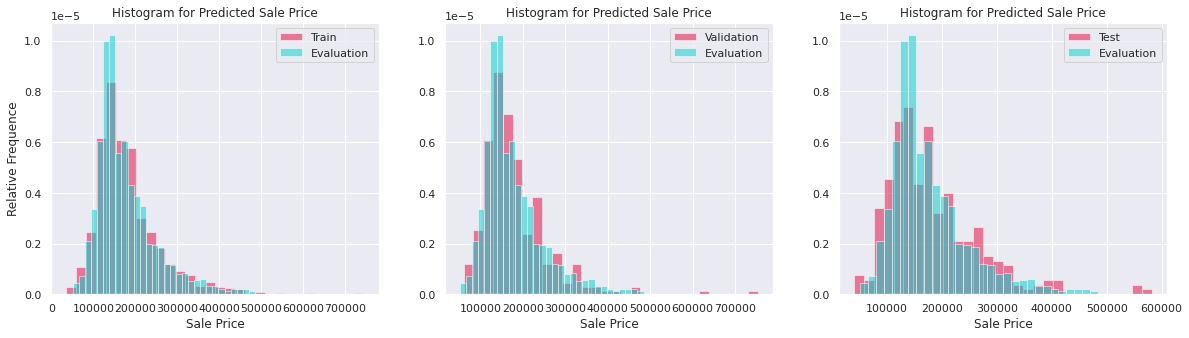

In [108]:
#  Load test data
df_evaluation = pd.read_csv("sample_submission.csv", sep=",")

# Make prediction over evaluation data
df_evaluation.iloc[:,1] = np.expm1(pd.DataFrame(rf_grid.predict(X_sub)))

# Plotting results for fast comparisson
# plt.hist(y_test)
f, axs = plt.subplots(2,2,figsize=(20,5))
plt.subplot(1, 3, 1)
plt.hist(np.expm1(y_train),alpha = 0.5, label='Train', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.ylabel('Relative Frequence')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.subplot(1, 3, 2)
plt.hist(np.expm1(y_val),alpha = 0.5, label='Validation', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.subplot(1, 3, 3)
plt.hist(np.expm1(y_test),alpha = 0.5, label='Test', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.show()

# Export file to submit in competition
# df_evaluation.to_csv(submissions_path + '/House_Prices_ART_RF_Jimenez_v2.csv', index = False)

# Applying Light GBM technique

In [109]:
# Set flag to train or load model 
# To load the model then: load_model = True
# To train the model then: load_model = False
load_model = True

print("======================================================================================")
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Validation shape:",x_val.shape)
print("Y Validation shape:",y_val.shape)
print("X Test shape:",x_test.shape)
print("Y Test shape:",y_test.shape)

start_time = time.time()
#Print the optimal hyperparameters
if load_model:
  # Load model
  infile = open(models_path + '/LGBM_model.pkl','rb')
  lgbm_grid = pickle.load(infile)
  infile = open(models_path + '/best_params_LGBM.pkl','rb')
  best_params = pickle.load(infile)
else:
  #Define the grid to be searched in
  lgbm = LGBMRegressor(n_estimators=50, random_state = random_state)

  # Create the random grid
  parameters = {  'max_depth':[-1,1, 5, 10, 20, 30, 50]
                , 'learning_rate':[0.0001, 0.001, 0.01, 0.1, 0.2] 
                , 'num_leaves':[10, 20,40,60,80]                               
                , 'reg_alpha':[0,0.01,0.03,0.1,0.5,1]                
                # , 'min_child_samples':[5,10,15,30,50,100,300,500]

                }

  #Execute cross-validated grid search
  lgbm_grid = TuneSearchCV(lgbm, param_distributions=parameters, n_trials = 30, early_stopping = False, n_jobs = -1, random_state = random_state )

  # Train Model
  lgbm_grid.fit(x_train,y_train)

  #Save model
  with open(models_path + '/LGBM_model.pkl', 'wb') as pickfile:
     pickle.dump(lgbm_grid, pickfile)
  with open(models_path + '/best_params_LGBM.pkl', 'wb') as pickfile:
     pickle.dump(best_params, pickfile)
print("======================================================================================")
print("Best parameters found: ")
print(lgbm_grid.best_params_)

print("======================================================================================")
# Predict values of regression with train
ypred_train = lgbm_grid.best_estimator_.predict(x_train)
# Predict values of regression with validation
ypred_val = lgbm_grid.best_estimator_.predict(x_val)
# Predict values of regression with test
ypred_test = lgbm_grid.best_estimator_.predict(x_test)

print("Evaluating results of the regression:")
print("RMSE Score for train, validation, test: {:.5f}, {:.5f}, {:.5f}".format(rmse(y_train, ypred_train), rmse(y_val, ypred_val), rmse(y_test, ypred_test)))

# Feature importance calculation
# imps = permutation_importance(lgbm_grid.best_estimator_, x_train, y_train)

# Create dummie variables and stack them with the previous dataframe
# importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
# importance.columns = ["variable","importance"]

# importance = importance.sort_values(by='importance', ascending=False)
print("======================================================================================")
print("Feature importance:")
# print(importance)

print("Ejecución: %s seconds" % (time.time() - start_time))

X Train shape: (873, 305)
Y Train shape: (873,)
X Validation shape: (291, 305)
Y Validation shape: (291,)
X Test shape: (291, 305)
Y Test shape: (291,)
Best parameters found: 
{'max_depth': 10, 'learning_rate': 0.1, 'num_leaves': 10, 'reg_alpha': 0.01}
Evaluating results of the regression:
RMSE Score for train, validation, test: 0.08702, 0.13121, 0.13398
Feature importance:
Ejecución: 0.12381601333618164 seconds


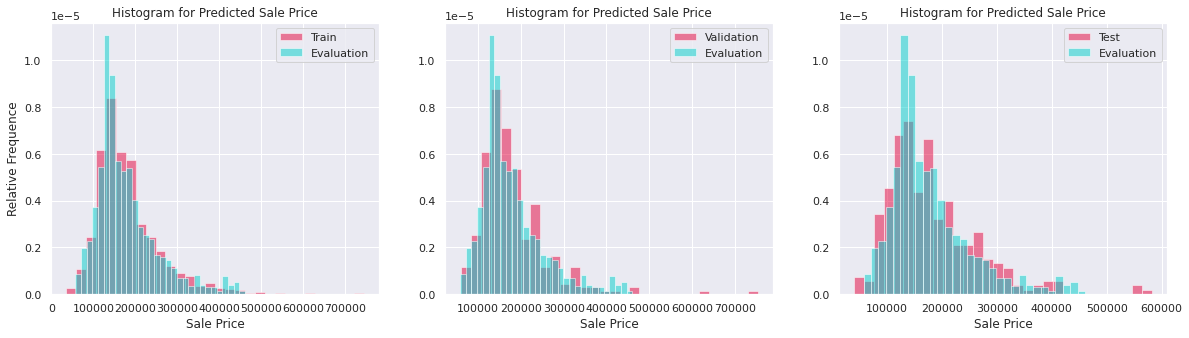

In [110]:
#  Load test data
df_evaluation = pd.read_csv("sample_submission.csv", sep=",")

# Make prediction over evaluation data
df_evaluation.iloc[:,1] = np.expm1(pd.DataFrame(lgbm_grid.predict(X_sub)))

# Plotting results for fast comparisson
# plt.hist(y_test)
f, axs = plt.subplots(2,2,figsize=(20,5))
plt.subplot(1, 3, 1)
plt.hist(np.expm1(y_train),alpha = 0.5, label='Train', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.ylabel('Relative Frequence')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.subplot(1, 3, 2)
plt.hist(np.expm1(y_val),alpha = 0.5, label='Validation', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.subplot(1, 3, 3)
plt.hist(np.expm1(y_test),alpha = 0.5, label='Test', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.show()

# Export file to submit in competition
# df_evaluation.to_csv(submissions_path + '/House_Prices_ART_LGBM_Jimenez_v2.csv', index = False)

# Applying Lasso regression technique

In [111]:
# Set flag to train or load model 
# To load the model then: load_model = True
# To train the model then: load_model = False
load_model = True

print("======================================================================================")
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Validation shape:",x_val.shape)
print("Y Validation shape:",y_val.shape)
print("X Test shape:",x_test.shape)
print("Y Test shape:",y_test.shape)

start_time = time.time()
#Print the optimal hyperparameters
if load_model:
  # Load model
  infile = open(models_path + '/Lasso_model.pkl','rb')
  lasso_grid = pickle.load(infile)

else:
  #Define the grid to be searched in
  lasso = Lasso(random_state = random_state)

  # Create the random grid
  parameters = {'alpha':[1e-6, 1e-5, 1e-4, 1e-3, 5e-2, 1e-2, 1e-1, 0.0, 0.3, 0.5, 0.7, 1.0, 10.0, 50.0, 100.0]}
  
  # Random search of parameters, using 5 fold cross validation, search across 100 different combinations, and use all available cores
  lasso_grid = RandomizedSearchCV(estimator = lasso, param_distributions = parameters, n_iter = 10, cv = 5, verbose=False, random_state = random_state, n_jobs = -1)
  # Fit the random search model
  lasso_grid.fit(x_train, y_train)

  #Save model
  with open(models_path + '/Lasso_model.pkl', 'wb') as pickfile:
     pickle.dump(lasso_grid, pickfile)

print("======================================================================================")
print("Best parameters found: ")
print(lasso_grid.best_params_)

print("======================================================================================")
# Predict values of regression with train
ypred_train = lasso_grid.best_estimator_.predict(x_train)
# ypred_train.columns = ['value']
# ypred_train['value']=np.where(ypred_train['value']<0, 0, ypred_train['value'])
# Predict values of regression with validation
ypred_val = lasso_grid.best_estimator_.predict(x_val)
# ypred_val.columns = ['value']
# ypred_val['value']=np.where(ypred_val['value']<0, 0, ypred_val['value'])
# Predict values of regression with test
ypred_test = lasso_grid.best_estimator_.predict(x_test)
# ypred_test.columns = ['value']
# ypred_test['value']=np.where(ypred_test['value']<0, 0, ypred_test['value'])

print("Evaluating results of the regression:")
print("RMSE Score for train, validation, test: {:.5f}, {:.5f}, {:.5f}".format(rmse(y_train, ypred_train), rmse(y_val, ypred_val), rmse(y_test, ypred_test)))

# Feature importance calculation
# imps = permutation_importance(lasso_grid.best_estimator_, x_train, y_train)

# Create dummie variables and stack them with the previous dataframe
# importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
# importance.columns = ["variable","importance"]

# importance = importance.sort_values(by='importance', ascending=False)
print("======================================================================================")
print("Feature importance:")
# print(importance)

print("Ejecución: %s seconds" % (time.time() - start_time))

X Train shape: (873, 305)
Y Train shape: (873,)
X Validation shape: (291, 305)
Y Validation shape: (291,)
X Test shape: (291, 305)
Y Test shape: (291,)
Best parameters found: 
{'alpha': 0.0001}
Evaluating results of the regression:
RMSE Score for train, validation, test: 0.08216, 0.12715, 0.11261
Feature importance:
Ejecución: 0.04523730278015137 seconds


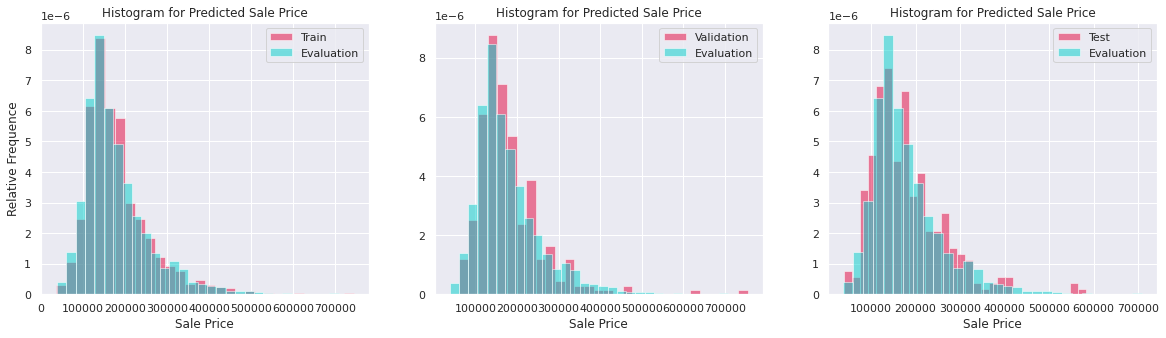

In [112]:
#  Load test data
df_evaluation = pd.read_csv("sample_submission.csv", sep=",")

# Make prediction over evaluation data
df_evaluation.iloc[:,1] = np.expm1(pd.DataFrame(lasso_grid.best_estimator_.predict(X_sub)))

# Plotting results for fast comparisson
# plt.hist(y_test)
f, axs = plt.subplots(2,2,figsize=(20,5))
plt.subplot(1, 3, 1)
plt.hist(np.expm1(y_train),alpha = 0.5, label='Train', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.ylabel('Relative Frequence')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.subplot(1, 3, 2)
plt.hist(np.expm1(y_val),alpha = 0.5, label='Validation', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.subplot(1, 3, 3)
plt.hist(np.expm1(y_test),alpha = 0.5, label='Test', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.show()

# Export file to submit in competition
# df_evaluation.to_csv(submissions_path + '/House_Prices_ART_LASSO_Jimenez_v2.csv', index = False)

# Applying Ridge regression technique

In [113]:
# Set flag to train or load model 
# To load the model then: load_model = 
# To train the model then: load_model = False
load_model = True

print("======================================================================================")
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Validation shape:",x_val.shape)
print("Y Validation shape:",y_val.shape)
print("X Test shape:",x_test.shape)
print("Y Test shape:",y_test.shape)

start_time = time.time()
#Print the optimal hyperparameters
if load_model:
  # Load model
  infile = open(models_path + '/ridge_model.pkl','rb')
  ridge_grid = pickle.load(infile)
else:
  #Define the grid to be searched in
  ridge = Ridge(random_state = random_state)

  # Create the random grid
  parameters = {'alpha':[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 0.3,0.7, 1.0, 10.0, 20.0, 30.0, 100.0]}
  # Random search of parameters, using 5 fold cross validation, search across 100 different combinations, and use all available cores
  ridge_grid = RandomizedSearchCV(estimator = ridge, param_distributions = parameters, n_iter = 10, cv = 5, verbose=False, random_state = random_state , n_jobs = -1)
  # Fit the random search model
  ridge_grid.fit(x_train, y_train)
  #Save model
  with open(models_path + '/ridge_model.pkl', 'wb') as pickfile:
     pickle.dump(ridge_grid, pickfile)

print("======================================================================================")
print("Best parameters found: ")
print(ridge_grid.best_params_)

print("======================================================================================")
# Predict values of regression with train
ypred_train = ridge_grid.best_estimator_.predict(x_train)
# ypred_train.columns = ['value']
# ypred_train['value']=np.where(ypred_train['value']<0, 0, ypred_train['value'])
# Predict values of regression with validation
ypred_val = ridge_grid.best_estimator_.predict(x_val)
# ypred_val.columns = ['value']
# ypred_val['value']=np.where(ypred_val['value']<0, 0, ypred_val['value'])
# Predict values of regression with test
ypred_test = ridge_grid.best_estimator_.predict(x_test)
# ypred_test.columns = ['value']
# ypred_test['value']=np.where(ypred_test['value']<0, 0, ypred_test['value'])

print("Evaluating results of the regression:")
print("RMSE Score for train, validation, test: {:.5f}, {:.5f}, {:.5f}".format(rmse(y_train, ypred_train), rmse(y_val, ypred_val), rmse(y_test, ypred_test)))

# Feature importance calculation
# imps = permutation_importance(ridge_grid.best_estimator_, x_train, y_train)

# Create dummie variables and stack them with the previous dataframe
# importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
# importance.columns = ["variable","importance"]

# importance = importance.sort_values(by='importance', ascending=False)
print("======================================================================================")
print("Feature importance:")
# print(importance)

print("Ejecución: %s seconds" % (time.time() - start_time))

X Train shape: (873, 305)
Y Train shape: (873,)
X Validation shape: (291, 305)
Y Validation shape: (291,)
X Test shape: (291, 305)
Y Test shape: (291,)
Best parameters found: 
{'alpha': 10.0}
Evaluating results of the regression:
RMSE Score for train, validation, test: 0.10106, 0.12530, 0.11677
Feature importance:
Ejecución: 0.047238826751708984 seconds


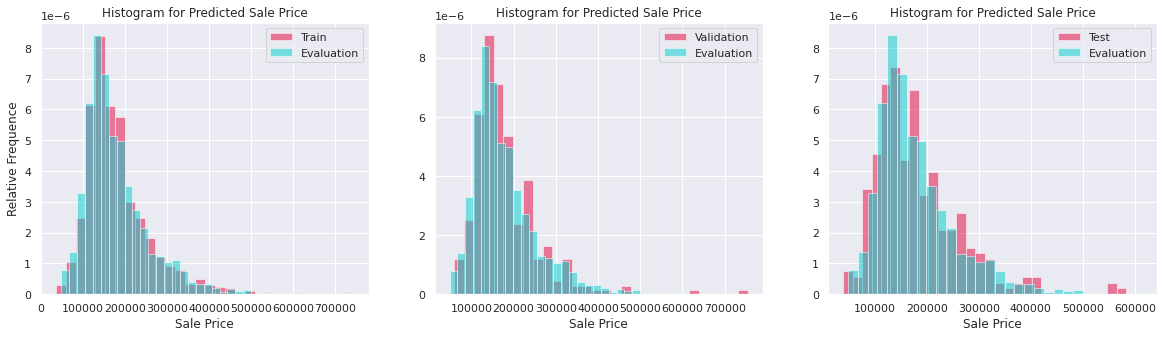

In [114]:
#  Load test data
df_evaluation = pd.read_csv("sample_submission.csv", sep=",")

# Make prediction over evaluation data
df_evaluation.iloc[:,1] = np.expm1(pd.DataFrame(ridge_grid.best_estimator_.predict(X_sub)))

# Plotting results for fast comparisson
# plt.hist(y_test)
f, axs = plt.subplots(2,2,figsize=(20,5))
plt.subplot(1, 3, 1)
plt.hist(np.expm1(y_train),alpha = 0.5, label='Train', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.ylabel('Relative Frequence')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.subplot(1, 3, 2)
plt.hist(np.expm1(y_val),alpha = 0.5, label='Validation', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.subplot(1, 3, 3)
plt.hist(np.expm1(y_test),alpha = 0.5, label='Test', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.show()

# Export file to submit in competition
# df_evaluation.to_csv(submissions_path + '/House_Prices_ART_RIDGE_Jimenez_v2.csv', index = False)

# Applying Elastic net regression technique

In [115]:
# Set flag to train or load model 
# To load the model then: load_model = 
# To train the model then: load_model = False
load_model = True

print("======================================================================================")
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Validation shape:",x_val.shape)
print("Y Validation shape:",y_val.shape)
print("X Test shape:",x_test.shape)
print("Y Test shape:",y_test.shape)

start_time = time.time()
#Print the optimal hyperparameters
if load_model:
  # Load model
  infile = open(models_path + '/elasticnet_model.pkl','rb')
  elasticnet_grid = pickle.load(infile)
else:
  #Define the grid to be searched in
  elasticnet = ElasticNet(random_state=12345)

  # Create the random grid
  parameters = {'alpha':[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
                ,'l1_ratio': np.arange(0, 1, 0.01)}
  # Random search of parameters, using 5 fold cross validation, search across 100 different combinations, and use all available cores
  elasticnet_grid = RandomizedSearchCV(estimator = elasticnet, param_distributions = parameters, n_iter = 10, cv = 5, verbose=False, random_state = random_state , n_jobs = -1)
  # Fit the random search model
  elasticnet_grid.fit(x_train, y_train)
  
  #Save model
  with open(models_path + '/elasticnet_model.pkl', 'wb') as pickfile:
     pickle.dump(elasticnet_grid, pickfile)
print("======================================================================================")
print("Best parameters found: ")
print(elasticnet_grid.best_params_)

print("======================================================================================")
# Predict values of regression with train
ypred_train = elasticnet_grid.best_estimator_.predict(x_train)
# ypred_train.columns = ['value']
# ypred_train['value']=np.where(ypred_train['value']<0, 0, ypred_train['value'])
# Predict values of regression with validation
ypred_val = elasticnet_grid.best_estimator_.predict(x_val)
# ypred_val.columns = ['value']
# ypred_val['value']=np.where(ypred_val['value']<0, 0, ypred_val['value'])
# Predict values of regression with test
ypred_test = elasticnet_grid.best_estimator_.predict(x_test)
# ypred_test.columns = ['value']
# ypred_test['value']=np.where(ypred_test['value']<0, 0, ypred_test['value'])

print("Evaluating results of the regression:")
print("RMSE Score for train, validation, test: {:.5f}, {:.5f}, {:.5f}".format(rmse(y_train, ypred_train), rmse(y_val, ypred_val), rmse(y_test, ypred_test)))

# Feature importance calculation
# imps = permutation_importance(elasticnet_grid.best_estimator_, x_train, y_train)

# Create dummie variables and stack them with the previous dataframe
# importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
# importance.columns = ["variable","importance"]

# importance = importance.sort_values(by='importance', ascending=False)
print("======================================================================================")
print("Feature importance:")
# print(importance)

print("Ejecución: %s seconds" % (time.time() - start_time))

X Train shape: (873, 305)
Y Train shape: (873,)
X Validation shape: (291, 305)
Y Validation shape: (291,)
X Test shape: (291, 305)
Y Test shape: (291,)
Best parameters found: 
{'l1_ratio': 0.72, 'alpha': 0.001}
Evaluating results of the regression:
RMSE Score for train, validation, test: 0.10462, 0.12619, 0.11444
Feature importance:
Ejecución: 0.04021120071411133 seconds


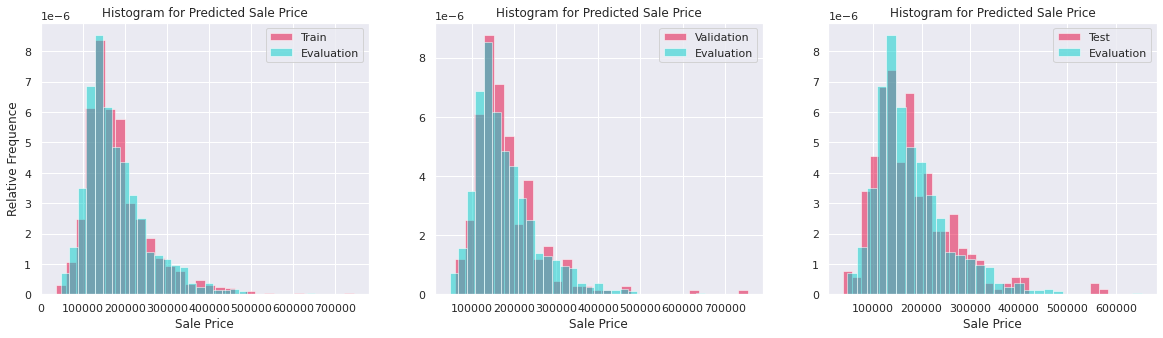

In [116]:
#  Load test data
df_evaluation = pd.read_csv("sample_submission.csv", sep=",")

# Make prediction over evaluation data
df_evaluation.iloc[:,1] = np.expm1(pd.DataFrame(elasticnet_grid.best_estimator_.predict(X_sub)))

# Plotting results for fast comparisson
# plt.hist(y_test)
f, axs = plt.subplots(2,2,figsize=(20,5))
plt.subplot(1, 3, 1)
plt.hist(np.expm1(y_train),alpha = 0.5, label='Train', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.ylabel('Relative Frequence')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.subplot(1, 3, 2)
plt.hist(np.expm1(y_val),alpha = 0.5, label='Validation', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.subplot(1, 3, 3)
plt.hist(np.expm1(y_test),alpha = 0.5, label='Test', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.show()

# Export file to submit in competition
# df_evaluation.to_csv(submissions_path + '/House_Prices_ART_ENET_Jimenez_v2.csv', index = False)

# Applying Support Vector Machine technique

In [117]:
# Set flag to train or load model 
# To load the model then: load_model = True
# To train the model then: load_model = False
load_model = True

print("======================================================================================")
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Validation shape:",x_val.shape)
print("Y Validation shape:",y_val.shape)
print("X Test shape:",x_test.shape)
print("Y Test shape:",y_test.shape)

start_time = time.time()
#Print the optimal hyperparameters
if load_model:
  # Load model
  infile = open(models_path + '/SVM_model.pkl','rb')
  svm_grid = pickle.load(infile)
  infile = open(models_path + '/best_params_SVM.pkl','rb')
  best_params = pickle.load(infile)
else:
  # Define function to minimize  
  def param_selection_cv(params, random_state=random_state, cv=kf, X=x_train, y=y_train):
      
      # Use params to create new model
      model = make_pipeline(RobustScaler(), SVR(cache_size=7000, **params))
     
      # Do cross validation with the same folds
      score = -cross_val_score(model, X, y, cv=cv, scoring="neg_root_mean_squared_error", n_jobs=-1,error_score='raise').mean()

      return score

  # Define grid (space)
  parameters = {'C': hp.choice('C', [0.01, 0.1, 1, 10, 20, 100])
                , 'kernel': hp.choice('kernel',['poly', 'rbf', 'sigmoid'])
                , 'degree':hp.choice('degree',[2,3,4])
                # , 'gamma': hp.choice('gamma',[1, 0.1, 0.01, 0.001])
      }
  # Minimize function
  best = fmin(fn = param_selection_cv, 
            space = parameters, 
            algo = tpe.suggest, 
            max_evals = 30
            , rstate = np.random.RandomState(random_state)
          )
  # Retrieve best hyperparameters
  best_params = space_eval(parameters, best)
  
  # Define model with best hyperparameters
  svm_grid = make_pipeline(RobustScaler(), SVR(cache_size=7000, C=best_params['C']
                                               , kernel=best_params['kernel']
                                              #  , gamma=best_params['gamma']
                                                , degree=best_params['degree']
                                               ))
  # Train model
  svm_grid.fit(x_train,y_train)

  #Save model
  with open(models_path + '/SVM_model.pkl', 'wb') as pickfile:
     pickle.dump(svm_grid, pickfile)
  with open(models_path + '/best_params_SVM.pkl', 'wb') as pickfile:
     pickle.dump(best_params, pickfile)

print("======================================================================================")
print("Best parameters found: ")
print(best_params)

print("======================================================================================")
# Predict values of regression with train
ypred_train = svm_grid.predict(x_train)
# Predict values of regression with validation
ypred_val = svm_grid.predict(x_val)
# Predict values of regression with test
ypred_test = svm_grid.predict(x_test)

print("Evaluating results of the regression:")
print("RMSE Score for train, validation, test: {:.5f}, {:.5f}, {:.5f}".format(rmse(y_train, ypred_train), rmse(y_val, ypred_val), rmse(y_test, ypred_test)))

# Feature importance calculation
# imps = permutation_importance(svm_grid, x_train, y_train)

# Create dummie variables and stack them with the previous dataframe
# importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
# importance.columns = ["variable","importance"]

# importance = importance.sort_values(by='importance', ascending=False)
print("======================================================================================")
print("Feature importance:")
# print(importance)

print("Ejecución: %s seconds" % (time.time() - start_time))

X Train shape: (873, 305)
Y Train shape: (873,)
X Validation shape: (291, 305)
Y Validation shape: (291,)
X Test shape: (291, 305)
Y Test shape: (291,)
Best parameters found: 
{'C': 1, 'degree': 4, 'kernel': 'rbf'}
Evaluating results of the regression:
RMSE Score for train, validation, test: 0.09116, 0.13758, 0.13108
Feature importance:
Ejecución: 0.14662480354309082 seconds


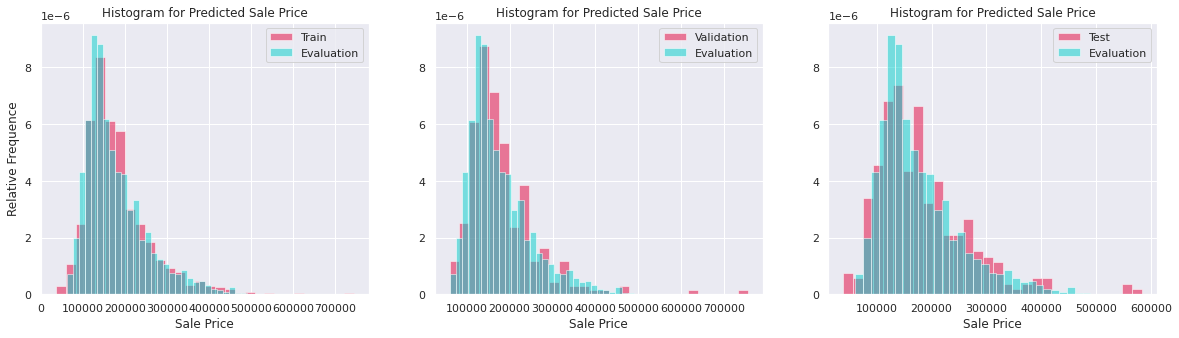

In [118]:
#  Load test data
df_evaluation = pd.read_csv("sample_submission.csv", sep=",")

# Make prediction over evaluation data
df_evaluation.iloc[:,1] = np.expm1(pd.DataFrame(svm_grid.predict(X_sub)))

# Plotting results for fast comparisson
# plt.hist(y_test)
f, axs = plt.subplots(2,2,figsize=(20,5))
plt.subplot(1, 3, 1)
plt.hist(np.expm1(y_train),alpha = 0.5, label='Train', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.ylabel('Relative Frequence')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.subplot(1, 3, 2)
plt.hist(np.expm1(y_val),alpha = 0.5, label='Validation', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.subplot(1, 3, 3)
plt.hist(np.expm1(y_test),alpha = 0.5, label='Test', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.show()

# Export file to submit in competition
# df_evaluation.to_csv(submissions_path + '/House_Prices_ART_SVM_Jimenez_v2.csv', index = False)

# Applying Gradient Boosting technique

In [119]:
# Set flag to train or load model 
# To load the model then: load_model = True
# To train the model then: load_model = False
load_model = True

print("======================================================================================")
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Validation shape:",x_val.shape)
print("Y Validation shape:",y_val.shape)
print("X Test shape:",x_test.shape)
print("Y Test shape:",y_test.shape)

start_time = time.time()
#Print the optimal hyperparameters
if load_model:
  # Load model
  infile = open(models_path + '/GradientBoost_model.pkl','rb')
  gb_grid = pickle.load(infile)
  infile = open(models_path + '/best_params_GradientBoost.pkl','rb')
  best_params = pickle.load(infile)
else:
    # Define function to minimize
  def param_selection_cv(params, random_state=random_state, cv=kf, X=x_train, y=y_train):
      
      # Use params to create new model
      model = make_pipeline( GradientBoostingRegressor(random_state = random_state, **params))

      # Do cross validation with the same folds
      score = -cross_val_score(model, X, y, cv=cv, scoring="neg_root_mean_squared_error", n_jobs = -1,error_score = 'raise').mean()

      return score

  # Define grid (space)
  parameters = {'max_depth': hp.choice('max_depth', range(3,20,1))
        , 'min_samples_split': hp.choice('min_samples_split', range(1,10,1))
        , 'n_estimators': hp.choice('n_estimators', [300])
        # , 'max_leaf_nodes': hp.choice('max_leaf_nodes', [2, 5, 10, 20, 50, 100])
        # , 'min_samples_leaf': hp.choice('min_samples_leaf', range(10,71,10))
        # , 'learning_rate': hp.choice('learning_rate', [0.0001, 0.001, 0.01, 0.1, 0.2] )

    }

  # Minimize function
  best = fmin(fn = param_selection_cv 
            , space = parameters 
            , algo = tpe.suggest 
            , max_evals = 10
            , rstate = np.random.RandomState(random_state)
          )
  
  # Retrieve best hyperparameters
  best_params = space_eval(parameters, best)

  # Define model with best hyperparameters
  gb_grid = make_pipeline( GradientBoostingRegressor(random_state = random_state, **best_params))

  # Train Model
  gb_grid.fit(x_train,y_train)

  #Save model
  with open(models_path + '/GradientBoost_model.pkl', 'wb') as pickfile:
     pickle.dump(gb_grid, pickfile)
  with open(models_path + '/best_params_GradientBoost.pkl', 'wb') as pickfile:
     pickle.dump(best_params, pickfile)
     
print("======================================================================================")
print("Best parameters found: ")
print(best_params)

print("======================================================================================")
# Predict values of regression with train
ypred_train = gb_grid.predict(x_train)
# Predict values of regression with validation
ypred_val = gb_grid.predict(x_val)
# Predict values of regression with test
ypred_test = gb_grid.predict(x_test)

print("Evaluating results of the regression:")
print("RMSE Score for train, validation, test: {:.5f}, {:.5f}, {:.5f}".format(rmse(y_train, ypred_train), rmse(y_val, ypred_val), rmse(y_test, ypred_test)))

# Feature importance calculation
# imps = permutation_importance(gb_grid, x_train, y_train)

# Create dummie variables and stack them with the previous dataframe
# importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
# importance.columns = ["variable","importance"]

# importance = importance.sort_values(by='importance', ascending=False)
print("======================================================================================")
print("Feature importance:")
# print(importance)

print("Ejecución: %s seconds" % (time.time() - start_time))

X Train shape: (873, 305)
Y Train shape: (873,)
X Validation shape: (291, 305)
Y Validation shape: (291,)
X Test shape: (291, 305)
Y Test shape: (291,)
Best parameters found: 
{'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 300}
Evaluating results of the regression:
RMSE Score for train, validation, test: 0.03598, 0.12593, 0.12484
Feature importance:
Ejecución: 0.07593131065368652 seconds


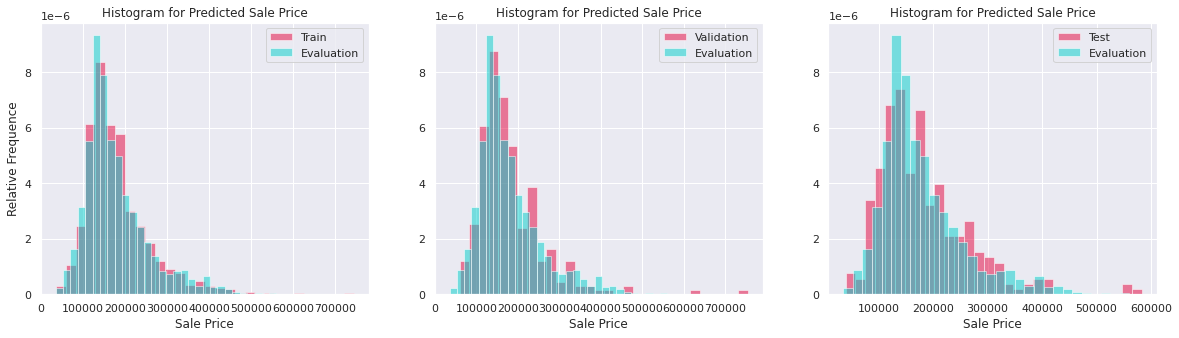

In [120]:
#  Load test data
df_evaluation = pd.read_csv("sample_submission.csv", sep=",")

# Make prediction over evaluation data
df_evaluation.iloc[:,1] = np.expm1(pd.DataFrame(gb_grid.predict(X_sub)))

# Plotting results for fast comparisson
# plt.hist(y_test)
f, axs = plt.subplots(2,2,figsize=(20,5))
plt.subplot(1, 3, 1)
plt.hist(np.expm1(y_train),alpha = 0.5, label='Train', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.ylabel('Relative Frequence')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.subplot(1, 3, 2)
plt.hist(np.expm1(y_val),alpha = 0.5, label='Validation', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.subplot(1, 3, 3)
plt.hist(np.expm1(y_test),alpha = 0.5, label='Test', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.show()

# Export file to submit in competition
# df_evaluation.to_csv(submissions_path + '/House_Prices_ART_GB_Jimenez_v2.csv', index = False)

# Applying Cat Boost technique

In [121]:
# Set flag to train or load model 
# To load the model then: load_model = True
# To train the model then: load_model = False
load_model = True

print("======================================================================================")
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Validation shape:",x_val.shape)
print("Y Validation shape:",y_val.shape)
print("X Test shape:",x_test.shape)
print("Y Test shape:",y_test.shape)

start_time = time.time()
#Print the optimal hyperparameters
if load_model:
  # Load model
  infile = open(models_path + '/CatBoost_model.pkl','rb')
  cat_model_f = pickle.load(infile)
  infile = open(models_path + '/params_CatBoost_model.pkl','rb')
  best_params = pickle.load(infile)

else:
  # Define function to minimize
  def param_selection_cv(params, random_state=random_state, cv=kf, X=x_train, y=y_train):
      
      # Use params to create new model
      model = make_pipeline( CatBoostRegressor(random_state = random_state, **params))

      # Do cross validation with the same folds
      score = -cross_val_score(model, X, y, cv=cv, scoring="neg_root_mean_squared_error", n_jobs = -1,error_score = 'raise').mean()

      return score

  # Define grid (space)
  # parameters = {'iterations': hp.choice('iterations', [1000,6000])
  parameters = {'iterations': hp.choice('iterations', [250,100,500,1000, 2000])
        , 'eval_metric': hp.choice('eval_metric', ['RMSE'])
        , 'early_stopping_rounds': hp.choice('early_stopping_rounds', [200])
        , 'learning_rate': hp.choice('learning_rate', [0.05, 0.005, 0.0005])
        , 'l2_leaf_reg': hp.choice('l2_leaf_reg', [1, 3, 5, 9])
        # , 'depth': hp.choice('depth', [4, 6, 10])
    }
# 
  # Minimize function
  best = fmin(fn = param_selection_cv 
            , space = parameters 
            , algo = tpe.suggest 
            , max_evals = 10
            , rstate = np.random.RandomState(random_state)
          )
  
  # Retrieve best hyperparameters
  best_params = space_eval(parameters, best)

  # Define model with best hyperparameters
  cat_f = make_pipeline( CatBoostRegressor(random_state = random_state, **best_params))  

  # Train model  
  cat_model_f = cat_f.fit(x_train,y_train)

  #Save model
  with open(models_path + '/CatBoost_model.pkl', 'wb') as pickfile:
     pickle.dump(cat_model_f, pickfile)
  with open(models_path + '/params_CatBoost_model.pkl', 'wb') as pickfile:
     pickle.dump(best_params, pickfile)

print("======================================================================================")
print("Best parameters found: ")
print(best_params)

print("======================================================================================")
# Predict values of regression with train
ypred_train = cat_model_f.predict(x_train)
# Predict values of regression with validation
ypred_val = cat_model_f.predict(x_val)
# Predict values of regression with test
ypred_test = cat_model_f.predict(x_test)

print("Evaluating results of the regression:")
print("RMSE Score for train, validation, test: {:.5f}, {:.5f}, {:.5f}".format(rmse(y_train, ypred_train), rmse(y_val, ypred_val), rmse(y_test, ypred_test)))

# Feature importance calculation
# imps = permutation_importance(cat_model_f, x_train, y_train)

# Create dummie variables and stack them with the previous dataframe
# importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
# importance.columns = ["variable","importance"]

# importance = importance.sort_values(by='importance', ascending=False)
print("======================================================================================")
print("Feature importance:")
# print(importance)

print("Ejecución: %s seconds" % (time.time() - start_time))

X Train shape: (873, 305)
Y Train shape: (873,)
X Validation shape: (291, 305)
Y Validation shape: (291,)
X Test shape: (291, 305)
Y Test shape: (291,)
Best parameters found: 
{'early_stopping_rounds': 200, 'eval_metric': 'RMSE', 'iterations': 1000, 'l2_leaf_reg': 3, 'learning_rate': 0.05}
Evaluating results of the regression:
RMSE Score for train, validation, test: 0.02055, 0.12835, 0.11890
Feature importance:
Ejecución: 0.26564979553222656 seconds


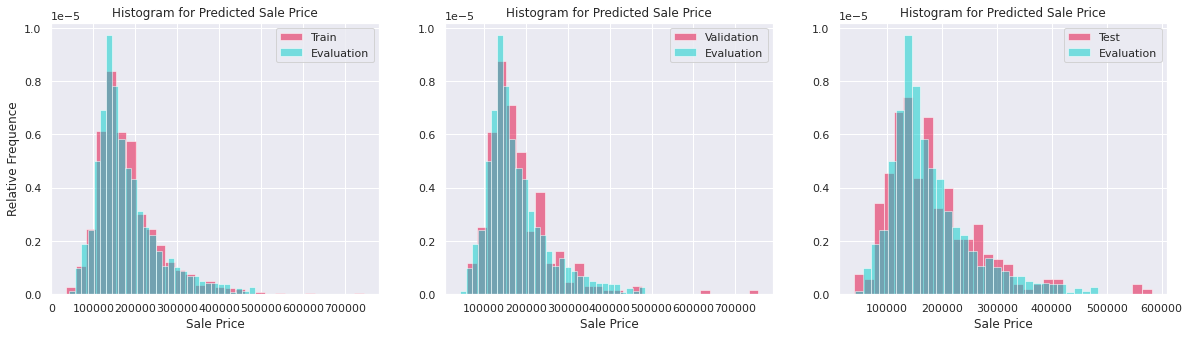

In [122]:
#  Load test data
df_evaluation = pd.read_csv("sample_submission.csv", sep=",")

# Make prediction over evaluation data
df_evaluation.iloc[:,1] = np.expm1(pd.DataFrame(cat_model_f.predict(X_sub)))

# Plotting results for fast comparisson
# plt.hist(y_test)
f, axs = plt.subplots(2,2,figsize=(20,5))
plt.subplot(1, 3, 1)
plt.hist(np.expm1(y_train),alpha = 0.5, label='Train', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.ylabel('Relative Frequence')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.subplot(1, 3, 2)
plt.hist(np.expm1(y_val),alpha = 0.5, label='Validation', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.subplot(1, 3, 3)
plt.hist(np.expm1(y_test),alpha = 0.5, label='Test', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.show()

# Export file to submit in competition
# df_evaluation.to_csv(submissions_path + '/House_Prices_ART_CATBOOST_Jimenez_v2.csv', index = False)

# Applying Artificial Neural Network technique

In [123]:
# Set flag to train or load model 
# To load the model then: load_model = True
# To train the model then: load_model = False
load_model = True

print("======================================================================================")
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Validation shape:",x_val.shape)
print("Y Validation shape:",y_val.shape)
print("X Test shape:",x_test.shape)
print("Y Test shape:",y_test.shape)

start_time = time.time()
#Print the optimal hyperparameters
if load_model:
  # Load model
  infile = open(models_path + '/ANN_model.pkl','rb')
  ann_grid = pickle.load(infile)
  infile = open(models_path + '/best_params_ANN.pkl','rb')
  best_params = pickle.load(infile)
else:
  # Define function to minimize  
  def param_selection_cv(params, random_state=random_state, cv=kf, X=x_train, y=y_train):
      # print(params)
      # Use params to create new model
      model = make_pipeline(RobustScaler(), MLPRegressor(random_state=random_state, max_iter=300, **params, early_stopping= True))
     
      # Do cross validation with the same folds
      score = -cross_val_score(model, X, y, cv=cv, scoring="neg_root_mean_squared_error", n_jobs=-1,error_score='raise').mean()

      return score

  # Define grid (space)
  parameters = {'hidden_layer_sizes': hp.choice('hidden_layer_sizes', [(50,), (100,), (300,), (50,50,50), (100,100,100), (300,300,300), (50,100,50), (100,300,100), (300,100,300), (500,500,500,500)])
                #  'hidden_layer_sizes': 100 + hp.randint('hidden_layer_sizes', 40)
                # , 'alpha': hp.loguniform('alpha', -8*np.log(10), 3*np.log(10))
                , 'alpha': hp.choice('alpha', [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]) 
                , 'activation':hp.choice('activation', ['relu', 'logistic', 'tanh'])
                , 'solver': hp.choice('solver', ['lbfgs', 'adam'])
                , 'learning_rate': hp.choice('learning_rate', ['invscaling', 'constant','adaptive'])
      }
 
  # Minimize function
  best = fmin(fn = param_selection_cv, 
            space = parameters, 
            algo = tpe.suggest, 
            max_evals = 30
            , rstate = np.random.RandomState(random_state)
          )
  # Retrieve best hyperparameters
  best_params = space_eval(parameters, best)
  
  ann_grid = make_pipeline(RobustScaler(), MLPRegressor(random_state=random_state, max_iter=300, **best_params, early_stopping= True))

  # Train model
  ann_grid.fit(x_train,y_train)

  #Save model
  with open(models_path + '/ANN_model.pkl', 'wb') as pickfile:
     pickle.dump(ann_grid, pickfile)
  with open(models_path + '/best_params_ANN.pkl', 'wb') as pickfile:
     pickle.dump(best_params, pickfile)

print("======================================================================================")
print("Best parameters found: ")
print(best_params)

print("======================================================================================")
# Predict values of regression with train
ypred_train = ann_grid.predict(x_train)
# Predict values of regression with validation
ypred_val = ann_grid.predict(x_val)
# Predict values of regression with test
ypred_test = ann_grid.predict(x_test)

print("Evaluating results of the regression:")
print("RMSE Score for train, validation, test: {:.5f}, {:.5f}, {:.5f}".format(rmse(y_train, ypred_train), rmse(y_val, ypred_val), rmse(y_test, ypred_test)))

# Feature importance calculation
# imps = permutation_importance(ann_grid, x_train, y_train)

# Create dummie variables and stack them with the previous dataframe
# importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
# importance.columns = ["variable","importance"]

# importance = importance.sort_values(by='importance', ascending=False)
print("======================================================================================")
print("Feature importance:")
# print(importance)

print("Ejecución: %s seconds" % (time.time() - start_time))

X Train shape: (873, 305)
Y Train shape: (873,)
X Validation shape: (291, 305)
Y Validation shape: (291,)
X Test shape: (291, 305)
Y Test shape: (291,)
Best parameters found: 
{'activation': 'tanh', 'alpha': 10.0, 'hidden_layer_sizes': (100,), 'learning_rate': 'invscaling', 'solver': 'lbfgs'}
Evaluating results of the regression:
RMSE Score for train, validation, test: 0.10999, 0.12636, 0.12480
Feature importance:
Ejecución: 0.07451128959655762 seconds


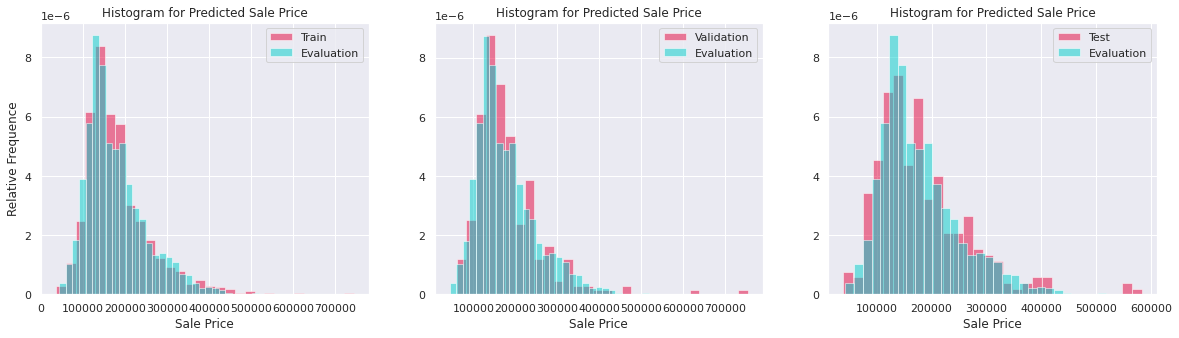

In [124]:
#  Load test data
df_evaluation = pd.read_csv("sample_submission.csv", sep=",")

# Make prediction over evaluation data
df_evaluation.iloc[:,1] = np.expm1(pd.DataFrame(ann_grid.predict(X_sub)))

# Plotting results for fast comparisson
# plt.hist(y_test)
f, axs = plt.subplots(2,2,figsize=(20,5))
plt.subplot(1, 3, 1)
plt.hist(np.expm1(y_train),alpha = 0.5, label='Train', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.ylabel('Relative Frequence')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.subplot(1, 3, 2)
plt.hist(np.expm1(y_val),alpha = 0.5, label='Validation', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.subplot(1, 3, 3)
plt.hist(np.expm1(y_test),alpha = 0.5, label='Test', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.show()

# Export file to submit in competition
# df_evaluation.to_csv(submissions_path + '/House_Prices_ART_ANN_Jimenez_v2.csv', index = False)

# Applying Decision Tree technique

In [125]:
# Set flag to train or load model 
# To load the model then: load_model = True
# To train the model then: load_model = False
load_model = True

print("======================================================================================")
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Validation shape:",x_val.shape)
print("Y Validation shape:",y_val.shape)
print("X Test shape:",x_test.shape)
print("Y Test shape:",y_test.shape)

start_time = time.time()
#Print the optimal hyperparameters
if load_model:
  # Load model
  infile = open(models_path + '/DT_model.pkl','rb')
  dt_grid = pickle.load(infile)
  infile = open(models_path + '/best_params_DT.pkl','rb')
  best_params = pickle.load(infile)
else:
  # Define function to minimize
  def param_selection_cv(params, random_state=random_state, cv=kf, X=x_train, y=y_train):
      # Use params to create new model
      model = make_pipeline( DecisionTreeRegressor(random_state = random_state, **params))
      
      # Do cross validation with the same folds
      score = -cross_val_score(model, X, y, cv=cv, scoring="neg_root_mean_squared_error", n_jobs = -1,error_score = 'raise').mean()

      return score

  # Define grid (space)
  parameters = {'max_depth': hp.choice('max_depth', range(3,20,1))
        , 'min_samples_leaf': hp.choice('min_samples_leaf', [0.001, 0.01, 0.1, 0.2, 0.5, 1, 10, 50, 100, ])
        , 'max_features' : hp.choice('max_features', [0.2, 0.4,0.6, 0.8, "auto","log2","sqrt",None])
        , 'splitter':hp.choice('splitter', ["best","random"])
        , "max_leaf_nodes":hp.choice('max_leaf_nodes', [None,10,20,30,40,50,60,70,80,90])
        # , "min_weight_fraction_leaf":hp.choice('min_weight_fraction_leaf', [0.001, 0.01, 0.1,0.2,0.3,0.4,0.5])
    }

  # Minimize function
  best = fmin(fn = param_selection_cv 
            , space = parameters 
            , algo = tpe.suggest 
            , max_evals = 20
            , rstate = np.random.RandomState(random_state)
          )
  
  # Retrieve best hyperparameters
  best_params = space_eval(parameters, best)

  # Define model with best hyperparameters
  dt_grid = make_pipeline( DecisionTreeRegressor(random_state = random_state, **best_params))

  # Train Model
  dt_grid.fit(x_train,y_train)
  
  #Save model
  with open(models_path + '/DT_model.pkl', 'wb') as pickfile:
     pickle.dump(dt_grid, pickfile)
  with open(models_path + '/best_params_DT.pkl', 'wb') as pickfile:
     pickle.dump(best_params, pickfile)
print("======================================================================================")
print("Best parameters found: ")
print(best_params)

print("======================================================================================")
# Predict values of regression with train
ypred_train = dt_grid.predict(x_train)
# Predict values of regression with validation
ypred_val = dt_grid.predict(x_val)
# Predict values of regression with test
ypred_test = dt_grid.predict(x_test)

print("Evaluating results of the regression:")
print("RMSE Score for train, validation, test: {:.5f}, {:.5f}, {:.5f}".format(rmse(y_train, ypred_train), rmse(y_val, ypred_val), rmse(y_test, ypred_test)))

# Feature importance calculation
# imps = permutation_importance(dt_grid, x_train, y_train)

# Create dummie variables and stack them with the previous dataframe
# importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
# importance.columns = ["variable","importance"]

# importance = importance.sort_values(by='importance', ascending=False)
print("======================================================================================")
print("Feature importance:")
# print(importance)

print("Ejecución: %s seconds" % (time.time() - start_time))

X Train shape: (873, 305)
Y Train shape: (873,)
X Validation shape: (291, 305)
Y Validation shape: (291,)
X Test shape: (291, 305)
Y Test shape: (291,)
Best parameters found: 
{'max_depth': 13, 'max_features': 0.6, 'max_leaf_nodes': 70, 'min_samples_leaf': 0.01, 'splitter': 'best'}
Evaluating results of the regression:
RMSE Score for train, validation, test: 0.12475, 0.18872, 0.21169
Feature importance:
Ejecución: 0.038863420486450195 seconds


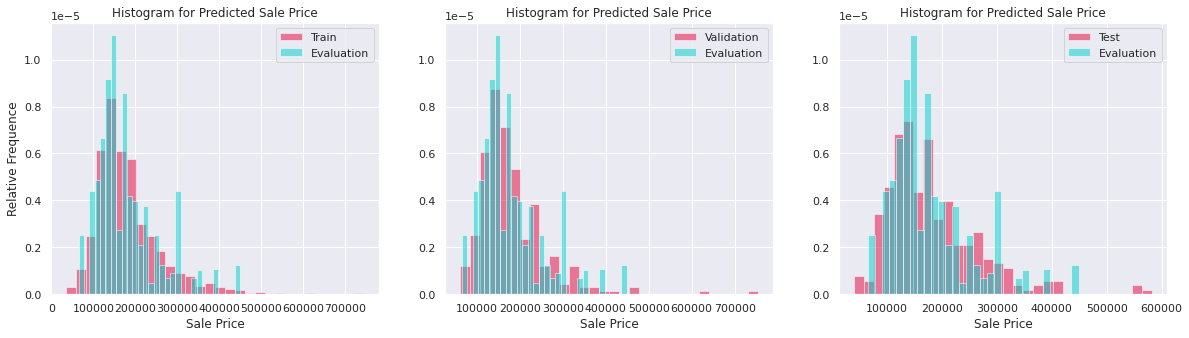

In [126]:
#  Load test data
df_evaluation = pd.read_csv("sample_submission.csv", sep=",")

# Make prediction over evaluation data
df_evaluation.iloc[:,1] = np.expm1(pd.DataFrame(dt_grid.predict(X_sub)))

# Plotting results for fast comparisson
# plt.hist(y_test)
f, axs = plt.subplots(2,2,figsize=(20,5))
plt.subplot(1, 3, 1)
plt.hist(np.expm1(y_train),alpha = 0.5, label='Train', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.ylabel('Relative Frequence')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.subplot(1, 3, 2)
plt.hist(np.expm1(y_val),alpha = 0.5, label='Validation', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.subplot(1, 3, 3)
plt.hist(np.expm1(y_test),alpha = 0.5, label='Test', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.show()

# Export file to submit in competition
# df_evaluation.to_csv(submissions_path + '/House_Prices_ART_ANN_Jimenez_v2.csv', index = False)

# Stacking models

In [127]:
# Set flag to train or load model 
# To load the model then: load_model = True
# To train the model then: load_model = False
load_model = True

print("======================================================================================")
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Validation shape:",x_val.shape)
print("Y Validation shape:",y_val.shape)
print("X Test shape:",x_test.shape)
print("Y Test shape:",y_test.shape)

start_time = time.time()
#Print the optimal hyperparameters
if load_model:
  # Load model and weights
  infile = open(models_path + '/Stacked_meta_XGBoost_model.pkl','rb')
  stack_gen_model = pickle.load(infile)
  infile = open(models_path + '/weights_meta_XGBoost_model.pkl','rb')
  best_w = pickle.load(infile)
  infile = open(models_path + '/rmse_meta_XGBoost_model.pkl','rb')
  best_rmse_w = pickle.load(infile)

else:
  # Stacking - combine multiple regression models with a meta-regressor. 
  stack_gen = StackingCVRegressor(regressors=(ridge_grid.best_estimator_, lasso_grid.best_estimator_, svm_grid, elasticnet_grid.best_estimator_, gb_grid, xgb_grid
                                            , lgbm_grid.best_estimator_, rf_grid, cat_model_f
                                            # , ann_grid, dt_grid
                                            ),
                                meta_regressor=xgb_grid,
                                use_features_in_secondary=True)
  # Train stacked model
  stack_gen_model = stack_gen.fit(np.array(x_train), np.array(y_train))
  # Calculate best weights for stacked prediction 
  best_w, best_rmse_w = get_best_weights(x_val, number_models = 10, n_trials = 100)
  
  #Save model and weights
  with open(models_path + '/Stacked_meta_XGBoost_model.pkl', 'wb') as pickfile:
     pickle.dump(stack_gen_model, pickfile)
  with open(models_path + '/weights_meta_XGBoost_model.pkl', 'wb') as pickfile:
     pickle.dump(best_w, pickfile)
  with open(models_path + '/rmse_meta_XGBoost_model.pkl', 'wb') as pickfile:
     pickle.dump(best_rmse_w, pickfile)

print("======================================================================================")
print("The best weighs are:", best_w)
print("The best rmse in validation was:", best_rmse_w)

print("======================================================================================")
# Predict values of regression with train
ypred_train = ensemble_models_predict(x_train, best_w)
# Predict values of regression with validation
ypred_val = ensemble_models_predict(x_val, best_w)
# Predict values of regression with test
ypred_test = ensemble_models_predict(x_test, best_w)

print("RMSE Score for train, validation, test: {:.5f}, {:.5f}, {:.5f}".format(rmse(y_train, ypred_train), rmse(y_val, ypred_val), rmse(y_test, ypred_test)))

# Feature importance calculation
# imps = permutation_importance(stack_gen_model, x_train, y_train)

# Create dummie variables and stack them with the previous dataframe
# importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
# importance.columns = ["variable","importance"]

# importance = importance.sort_values(by='importance', ascending=False)
print("======================================================================================")
print("Feature importance:")
# print(importance)


print("Ejecución: %s seconds" % (time.time() - start_time))

X Train shape: (873, 305)
Y Train shape: (873,)
X Validation shape: (291, 305)
Y Validation shape: (291,)
X Test shape: (291, 305)
Y Test shape: (291,)
[15:19:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:19:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:19:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
The best weighs are: [0.31187576 0.09165419 0.04828327 0.12636884 0.19039529 0.02332701
 0.05929965 0.09353029 0.04668766 0.00857805]
The best rmse in validation was: 0.12111779647074078
RMSE Score for train, validation, test: 0.05095, 0.12112, 0.11393
Feature importance:
Ejecución: 1.9582757949829102 seconds


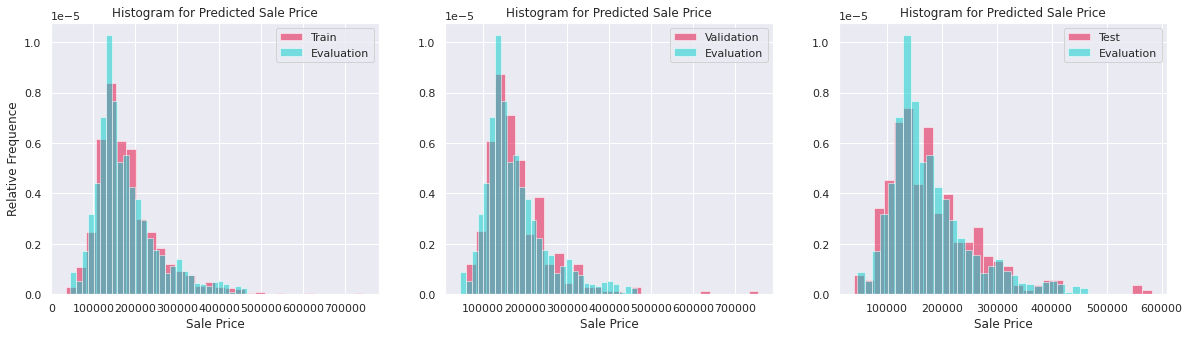

In [128]:
#  Load test data
df_evaluation = pd.read_csv("sample_submission.csv", sep=",")

# Make prediction over evaluation data
df_evaluation.iloc[:,1] = np.expm1(pd.DataFrame(ensemble_models_predict(X_sub, best_w)))

# Plotting results for fast comparisson
# plt.hist(y_test)
f, axs = plt.subplots(2,2,figsize=(20,5))
plt.subplot(1, 3, 1)
plt.hist(np.expm1(y_train),alpha = 0.5, label='Train', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.ylabel('Relative Frequence')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.subplot(1, 3, 2)
plt.hist(np.expm1(y_val),alpha = 0.5, label='Validation', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.subplot(1, 3, 3)
plt.hist(np.expm1(y_test),alpha = 0.5, label='Test', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.SalePrice,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Sale Price')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Sale Price')
plt.show()

# Export file to submit in competition
df_evaluation.to_csv(submissions_path + '/House_Prices_ART_ENSEMBLE_XGBoost_Jimenez_v4.csv', index = False)

# References

- https://www.kaggle.com/marto24/beginners-prediction-top3
- https://www.kaggle.com/dmitrikurochkin/house-sales-blending-models
- https://www.kaggle.com/salemeng1/stacked-regressions-top-4-on-leaderboard#Data-Processing